# Анализ данных о продаже автомобилей

Данные будут загружатся со следующего источника http://klaksona.net/

## Выбор параметров

In [1]:
RS = 654321
TS = 0.3

выбор рандом стаит и тест сплит

In [2]:
passs = 60

Выбор доли пропусков в столбцах подлежащих удалению

In [3]:
eur = 1.11

курс евро к доллару

In [4]:
pmr = 16.5

курс пмр к доллару

# Импорт библиотек и функций

In [5]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import phik
import time
import shap
import tqdm
from collections import Counter
import requests
from urllib.parse import urlencode
import json
import sys

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import ADASYN

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_seq_items', 1000)
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True 
#tqdm.pandas() 

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Загрузка функций

In [8]:
# Функция парсинга, которая создает датафрейм, в который добавляет информацию об инентификаторе, названии, ссылки, бренде, 
# дате парсинга, объеме двигателя, годе выпуска двигателя и цене автомобиля
j=1
def parsing_2(url):
    data = pd.DataFrame(columns=['id', 'title', 'url', 'date_parsing', 'brend',  'volume', 'тип_двигателя', 'год', 'prise']) 
    reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=1')
    soup = bs(reqx.text, 'html.parser')
    element = soup.findAll('a', class_="ajax_link")
    max_page = int(element[-8].text)
    for j in tqdm(range(1,max_page)):        
        reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=' + str(j))
        soup = bs(reqx.text, 'html.parser')
        element = soup.findAll('div', class_='border_type_0')
        datax = []
        for i in element:
            datax.append({'id'  : i.find('a')['href'].split('/')[-1].replace('.html',''),
                          'title' : i.find('h1').text.lstrip(' ').rstrip(' '),
                          'url' : i.find('a')['href'],
                          'brend' : i.find('h1').text.split(' ')[2],
                          'date_parsing' : pd.to_datetime('today').normalize(),
                          'volume'  : i.find('tr').text.split('\r\n')[3].replace(' ',''),
                          'тип_двигателя' : i.find('tr').text.split('\r\n')[7].replace(' ',''),
                          'год' : i.find('td').text.lstrip(' ').rstrip(' ').split(' ')[1].replace('г.',''),
                          'prise' : (str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[3]) + 
                                     str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[4]) + 
                                     str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[5]))
                         })
        datax = pd.DataFrame(datax)
        data = pd.concat([data, datax] , ignore_index=True)
    return data

reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=1' )
soup = bs(reqx.text, 'html.parser')
element = soup.findAll('div', class_='border_type_0')
element

element[2].find('tr').text.lstrip(' ').rstrip(' ').split(' ')[3]

element[2].find('tr').text.lstrip(' ').rstrip(' ').split(' ')[4]

element[2].find('tr').text.lstrip(' ').rstrip(' ').split(' ')[5]

In [9]:
# Функция которая добовляет в датафрейм дополнительную информацию а также информацию о классе автомобиля, типе кузова, 
# состоянии автомобиля, количестве дверей, потребляемом топриве и типе коробки передачь, наличии и типе климатической системы, 
# аудиосистемы, а также информацию о контактном лице его телефоне и дате размещения объявления


def add_details(x):
    reqx = requests.get(x)
    soup = bs(reqx.text, 'html.parser')
    element = soup.findAll('div', class_='container')
    lists = element[0].text.split('\n')
    if lists.count('Дополнительная информация:'):
        dop_info = lists.pop(lists.index('Дополнительная информация:') + 1).strip()
    else:
        dop_info = np.NaN
    if lists.count('Класс автомобиля:'):
        class_auto = lists.pop(lists.index('Класс автомобиля:') + 1).replace(' ','')
    else:
        class_auto = np.NaN
    if lists.count('Тип кузова:'):
        body = lists.pop(lists.index('Тип кузова:') + 1).replace(' ','')
    else:
        body = np.NaN
    if lists.count('Состояние:'):
        state = lists.pop(lists.index('Состояние:') + 1).replace(' ','')
    else:
        state = np.NaN  
    if lists.count('Кол-во дверей:'):
        door = lists.pop(lists.index('Кол-во дверей:') + 1).replace(' ','')
    else:
        door = np.NaN
    if lists.count('Потребляемое топливо:'):
        fuel = lists.pop(lists.index('Потребляемое топливо:') + 1).replace(' ','')
    else:
        fuel = np.NaN
    if lists.count('Коробка передач:'):
        transmission = lists.pop(lists.index('Коробка передач:') + 1).replace(' ','')
    else:
        transmission = np.NaN
    if lists.count('Кондиционер:'):
        conditioner = lists.pop(lists.index('Кондиционер:') + 1).replace(' ','')
    else:
        conditioner = np.NaN
    if lists.count('Аудиосистема:'):
        audio = lists.pop(lists.index('Аудиосистема:') + 1).replace(' ','')
    else:
        audio = np.NaN
    if lists.count('Пробег'):
        mileage = lists.pop(lists.index('Пробег') + 1).replace(' ','')
    else:
        mileage = np.NaN
    if lists.count('Контактное лицо'):
        contact = lists.pop(lists.index('Контактное лицо') + 1).replace(' ','')
    else:
        contact = np.NaN
    if lists.count('Телефон'):
        fone = lists.pop(lists.index('Телефон') + 1).replace(' ','')
    else:
        fone = np.NaN
    if lists.count('Размещено:'):
        date_notice = lists.pop(lists.index('Размещено:') + 1).replace(' ','')
    else:
        date_notice = np.NaN
    
    return pd.Series([dop_info, class_auto, body, state, door, fuel, transmission, conditioner, audio, mileage, contact, fone, date_notice])

In [10]:
# Функция преобразования даты загрузки объявления
def rename_date(x):
    x = str(x)
    dat = x[:-5] + ' ' + x[-5:]
    dat = dat.replace('сегодняв', str((df.loc[0, 'date_parsing']).strftime('%d.%m.%Y')))
    dat = dat.replace('вчерав', str((df.loc[0, 'date_parsing'] - pd.Timedelta(days=1)).strftime('%d.%m.%Y')))
    return dat

In [11]:
# Функция которая вырезает модель автомобиля из его названия
def model_name(x):
    x = str(x)
    x = x.split()
    return " ".join(x[1:])            

In [12]:
# функция которая формирует цену
def norm_price(x):
    if 'руб' in x:
        return round(int(x[:-4])/pmr)
    elif '$' in x:
        return round(int(x[:-1]))
    elif '€' in x:
        return round(int(x[:-1])*eur)
    else:
        return np.nan

In [13]:
# Функция для отображения количественного признака    
def show_numeric_feature(df, column, title, x_label, y_label):
    """
    Отображает гистограмму и "ящик с усами" для количественного признака.
    Параметры:
    - df: Датасет.
    - column: Название колонки признака.
    - title: Заголовок диаграммы.
    - x_label: Название оси X.
    - y_label: Название оси Y.   
    Пример:
    ```
    show_numeric_feature(market_file_df, 
                         'выручка',
                         'Выручка за период',
                         'Выручка',
                         'Количество покупателей')
    ```
    """    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plt.suptitle(title.upper(), fontsize=16, ha='center')
    sns.histplot(data=df[column], color='g', kde=False, ax=axes[0], bins=30) 
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    sns.boxplot(x=df[column], color='c')
    axes[1].set_xlabel(y_label)
    plt.show()
    print('Описание признака:', x_label)
    display(df[column].describe().T)
    
    
# Функция для отображения количественного признака по списку
def show_numeric_feature_by_list(df, features):
    """
    Отображает гистограмму и "ящик с усами" для количественного признака
    по списку.

    Параметры:
    - df: Датасет.
    - features: Список признаков для отображения.
   
    Пример:
    ```
    show_numeric_feature_by_list(market_file_df, 
        market_file_numeric_features)
    ```
    """    
    for feature in features:
        title = 'признак ' + feature
        column = feature
        x_label = 'признак ' + feature
        y_label = 'Количество'
        show_numeric_feature(df, column, title, x_label, y_label)        
        
# Функция для отображения категориального признака    
def show_categorical_feature(df, column, title, x_label, y_label):
    """
    Отображает столбчатую и круговую диаграммы для категориального признака.
    Параметры:
    - df: Датасет.
    - column: Название колонки признака.
    - title: Заголово диаграммы.
    - x_label: Название оси X.
    - y_label: Название оси Y.   
    Пример:
    ```
    show_categorical_feature(market_file_df, 
                         'покупательская_активность',
                         'класс покупательской активности',
                         'Покупательская активность',
                         'Количество покупателей')
    ```
    """    
    cat_df = df[column].value_counts()
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plt.suptitle(title.upper(), fontsize=16, ha='center')
    sns.barplot(x=cat_df.index,
                y=cat_df,
                color='g',
                ax=axes[0]) 
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[0].tick_params(labelrotation=0)
    axes[0].bar_label(axes[0].containers[0],
                      padding=-25,
                      color='white',
                      fontsize=12,
                      label_type='edge',
                      fontweight='bold')
    plt.pie(cat_df, 
            labels=cat_df.index, 
            autopct='%1.1f%%', 
            wedgeprops = { 'linewidth': 3, 'edgecolor': 'white' })
    axes[1].set_xlabel(x_label)
    plt.show()
# Функция для отображения категориального признака по списку
def show_categorical_feature_by_list(df, features):
    """
    Отображает столбчатую и круговую диаграммы для категориального признака
    по списку
    Параметры:
    - df: Датасет.
    - features: Список признаков для отображения.   
    Пример:
    ```
    show_categorical_feature_by_list(market_file_df, 
        market_file_categorical_features)
    ```
    """
    for feature in features:
        title = 'признак ' + feature
        column = feature
        x_label = 'признак ' + feature
        y_label = 'Количество' 
        show_categorical_feature(df, column, title, x_label, y_label);

In [14]:
#вспомогательная функция для построяния ящика с усами над гистограммой
def hist_underbox(data,title=None):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False};
    #sns.set_theme(style="darkgrid", rc=custom_params);
    #sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data, ax=ax_box).set_title(title)
    sns.histplot(x=data, ax=ax_hist, kde=True)
    ax_box.set(yticks=[])
    ax_box.set_xlabel("")
    ax_hist.set_ylabel("Количество")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    mean = ax_hist.axvline(data.mean(), color='r', lw=2)
    median = ax_hist.axvline(data.median(), color='k', ls='--', lw=2)
    ax_hist.legend([mean, median], [f'Среднее значение = {round(data.mean(),2)}',
                                    f'Медиана = {round(data.median(),2)}'],
                                    loc='best')

In [15]:
# Функция удаления фичей из датасета
def del_features(delete_features, categorical_nominal_features, categorical_ordinal_features, numerical_features, df):
    df = df.drop(columns = delete_features)
    features = [categorical_nominal_features, categorical_ordinal_features, numerical_features]
    for i in delete_features:
        for j in features:
            if i in j:
                j.remove(i)
    print(delete_features)
    if len(target + categorical_nominal_features + categorical_ordinal_features + numerical_features) == len(df.columns):
        print('OK')
    else:
        print('НЕ_ОК')   
    return categorical_nominal_features, categorical_ordinal_features, numerical_features, df

In [16]:
# Подготовка функции создания моделей
def create_model(model_name, pipeline, param_grid, X_train, X_test, y_train, y_test, scorer, models, results_models,  ):
    # Создание модели
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, scoring=scorer)
    # Обучение модели
    start_time = time.time()    
    grid_search.fit(X_train, y_train)        
    models[model_name]['training_time'] = round(time.time() - start_time, 2)
    # Сохраненение модели с лучшими результами
    models[model_name]['best_model'] = grid_search.best_estimator_
    # Формирование предсказаний
    start_time = time.time()
    models[model_name]['predictions'] = models[model_name]['best_model'].predict(X_train)
    models[model_name]['best_parametrs'] = grid_search.best_params_   
    #models[model_name]['probas'] = models[model_name]['best_model'].predict_proba(X_train)[:,1]    
    models[model_name]['prediction_time'] = round(time.time() - start_time, 2)
    # Сохранение лучшей метрики
    models[model_name][scorer] = round(grid_search.best_score_, 4)
    # Влияние на модель фичей
    models[model_name]['grid_search'] = grid_search
    predictions_test = grid_search.predict(X_test)
    predictions_train = grid_search.predict(X_train)

    models[model_name]['f1_train'] = round(f1_score(y_train, predictions_train, average='macro'),2)
    models[model_name]['f1_test'] = round(f1_score(y_test, predictions_test, average='macro'),2)

    results_models = pd.concat([results_models, pd.DataFrame([([
        model_name,
        models[model_name][scorer],
        models[model_name]['f1_train'],
        models[model_name]['f1_test'],
        models[model_name]['training_time'], 
        models[model_name]['prediction_time'],
        models[model_name]['param_grid'],
        models[model_name]['best_parametrs'],
        ])],columns=columns_results_models)], ignore_index=True)

    results_models['param_grid'] = results_models['param_grid'].astype(str)
    results_models['best_parametrs'] = results_models['best_parametrs'].astype(str)
    results_modelsx = results_models.drop_duplicates(['model', 'f1_macro', 'f1_train',
                                                      'f1_test', 'param_grid', 'best_parametrs'] ,keep='first')
    results_modelsx = results_modelsx.reset_index(drop=True)
    results_models.to_csv('results_models.csv', index=False)  

    print(f'Модель {model_name}')
    print('-' * 70)        
    print(f"f1-мера модели на трейне: {round(f1_score(y_train, predictions_train, average='macro'),2)}")
    print(f"f1-мера модели на тесте: {round(f1_score(y_test, predictions_test, average='macro'),2)}")
    print(f"f1-мера лучшей модели на кроссвалидации: {round(grid_search.best_score_,2)}")
    print('-' * 70)
    print(classification_report(y_train, predictions_train)) 
    print('-' * 70)    
    print(classification_report(y_test, predictions_test))    
    print('-' * 70)
    print(f'Время обучения: {models[model_name]["training_time"]} сек.')
    print(f'Время предсказания: {models[model_name]["prediction_time"]} сек.')
    #print(f'{scorer.upper()}: {models[model_name][scorer]}')
    print(f'Лучшие параметры: {models[model_name]["best_parametrs"]}')
    #print(f'Лучшая модель:{models[model_name]["best_model"]}')
     
    return results_modelsx, models

In [17]:
def preprocessing(x):
    x.columns = [i.lower().
                 replace('\\', '_').
                 replace('/', '_').
                 replace(' ', '_').
                 replace('.', '_').
                 replace(',', '_').
                 replace('(', '_').
                 replace(')', '_').
                 replace('-', '_').
                 replace('%', '_pct').
                 replace('__', '_').rstrip('_') for i in x.columns]
    print(f'таблица имеет следующий вид:')
    display(x.head())
    print('*'*100)
    print(f'таблица имеет {x.shape[0]} сторок и {x.shape[1]} столбцов')
    print('*'*100)
    print(f'в таблице обнаружено дубликатов:{x.duplicated().sum()}')
    print('*'*100)
    print('в таблице обнаружены пропуски в следующих столбцах:')
    display(x.isna().sum())
    print('*'*100)
    print('Эти пропуски составлябт следующее количество в процентах')
    display((x.isna().mean()* 100).round(1))
    print('*'*100)
    print('столбцы имеют следующие типы:')
    display(x.dtypes)
    print('*'*100)
    print('названия столбцов переписаны в нижнем регистре, пробелы заменены на нижнее подчеркивание')
    print('*'*100)
    display(x.info())

In [18]:
def show_metrics(predictions, y_test):
    f1 = f1_score(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)
    #precision = precision_score(y_test, predictions)
    #recall = recall_score(y_test, predictions)
    print(classification_report(y_test, predictions, ))
    print('F1 macro: ', round(f1, 2))
    print('Accuracy: ', round(accuracy, 2))
    #print('Precision: ', round(precision, 2))
    #print('Recall: ', round(recall, 2))
    print('-' * 70)
    print('Матрица ошибок')
    cm = confusion_matrix(y_test, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,)# display_labels = ["Negativ", "Positiv"])
    cm_display.plot()
    plt.tight_layout()
    plt.title('ConfusionMatrix')
    plt.grid(False)
    plt.show()

In [19]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Загрузка данных

In [20]:
oll_url=['http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=']

df = parsing_2(oll_url)

df[['dop_info', 'class_auto', 'body', 'state', 'door', 'fuel',
   'transmission', 'conditioner', 'audio', 'mileage', 'contact',
   'fone', 'date_notice']] = df['url'].progress_apply(add_details)

df.head()

df.to_csv('csv/klakson.csv', index=False) 

In [21]:
df = pd.read_csv('csv/klakson.csv')

# Предобработка данных

In [22]:
preprocessing(df)

таблица имеет следующий вид:


,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice
0,auto1691409,Lexus RX 400h,http://klaksona.net/avtorynok-pmr/auto1691409.html,2024-10-01,Lexus,3300,Гибрид,2009,10800$,NaN,Легковой,внедорожник,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитола,168000.00,Тирасполь,77904221,сегодняв14:57
1,auto1691408,Комплектующие кузовные детали,http://klaksona.net/avtorynok-pmr/auto1691408.html,2024-10-01,NaN,неуказано,неуказано,2006,договорная\n\n\n\n\n\n\n,"Передняя и задняя дверь Тойота Камри 40 под реставрацию, левая сторона, был удар по касательной.",Легковой,седан,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Анатолий,077799460,сегодняв14:55
2,auto1691407,Opel Rekord,http://klaksona.net/avtorynok-pmr/auto1691407.html,2024-10-01,Opel,2,Бензин-Газ,1983,650$,Опель рекорд.2.0 бензин газ пропан.650у.е торг.77779008. бендеры,NaN,NaN,NaN,NaN,газ,NaN,NaN,NaN,NaN,Авто,077779008,сегодняв14:55
3,auto1691406,Комплектующие диски и шины,http://klaksona.net/avtorynok-pmr/auto1691406.html,2024-10-01,NaN,неуказано,неуказано,2017,40$,"Продам пару шин Yоcohama 235/55/R18,стояли на машине без шишек порезов причина продажи, перешли на размер больше. Цена за пару,",Легковой,внедорожник,Удовлетворительное,NaN,NaN,NaN,NaN,NaN,NaN,Павел(Всеобъявленияэтогопользователя),77737529,сегодняв14:55
4,auto1691405,Комплектующие кузовные детали,http://klaksona.net/avtorynok-pmr/auto1691405.html,2024-10-01,NaN,неуказано,неуказано,2006,договорная\n\n\n\n\n\n\n,"Продам заднюю крышку багажника Тойота Авенсис т25 универсал, задний бампер, имеется крышка багажника на разбор.",Легковой,универсал,Хорошее,NaN,NaN,NaN,NaN,NaN,NaN,Анатолий,077799460,сегодняв14:53


****************************************************************************************************
таблица имеет 10280 сторок и 22 столбцов
****************************************************************************************************
в таблице обнаружено дубликатов:10
****************************************************************************************************
в таблице обнаружены пропуски в следующих столбцах:


id                  0
title               0
url                 0
date_parsing        0
brend            1711
volume              0
тип_двигателя       0
год                 0
prise               0
dop_info         1012
class_auto       2658
body             3034
state            2824
door             3542
fuel             3187
transmission     3047
conditioner      4005
audio            4821
mileage          3851
contact            10
fone                0
date_notice         0
dtype: int64

****************************************************************************************************
Эти пропуски составлябт следующее количество в процентах


id               0.00
title            0.00
url              0.00
date_parsing     0.00
brend           16.60
volume           0.00
тип_двигателя    0.00
год              0.00
prise            0.00
dop_info         9.80
class_auto      25.90
body            29.50
state           27.50
door            34.50
fuel            31.00
transmission    29.60
conditioner     39.00
audio           46.90
mileage         37.50
contact          0.10
fone             0.00
date_notice      0.00
dtype: float64

****************************************************************************************************
столбцы имеют следующие типы:


id                object
title             object
url               object
date_parsing      object
brend             object
volume            object
тип_двигателя     object
год                int64
prise             object
dop_info          object
class_auto        object
body              object
state             object
door              object
fuel              object
transmission      object
conditioner       object
audio             object
mileage          float64
contact           object
fone              object
date_notice       object
dtype: object

****************************************************************************************************
названия столбцов переписаны в нижнем регистре, пробелы заменены на нижнее подчеркивание
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10280 entries, 0 to 10279
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10280 non-null  object 
 1   title          10280 non-null  object 
 2   url            10280 non-null  object 
 3   date_parsing   10280 non-null  object 
 4   brend          8569 non-null   object 
 5   volume         10280 non-null  object 
 6   тип_двигателя  10280 non-null  object 
 7   год            10280 non-null  int64  
 8   prise          10280 non-null  object 
 9   dop_info       9268 non-null   object 
 10  class_auto     7622 non-null   object 
 11  body           7246 non

None

## Предобработка дублекатов

In [23]:
df.groupby('id')['title'].count().sort_values(ascending=False)

id
auto1691389    2
auto1691297    2
auto1691390    2
auto1691391    2
auto1691392    2
              ..
auto1586322    1
auto1586324    1
auto1586358    1
auto1586386    1
auto799009     1
Name: title, Length: 10270, dtype: int64

In [24]:
df[df.duplicated()]

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice
24,auto1691393,Mercedes-Benz S-klasse S 550,http://klaksona.net/avtorynok-pmr/auto1691393.html,2024-10-01,Mercedes-Benz,4663,Бензин,2013,договорная\n\n\n\n\n\n\n,"MERCEDES BENZ S550L AMG SPORT PACKAGE.Автомобиль выгодно отличается от безликой массы корпоративных W222: алмазно белый цвет, много хрома (AMG S63 package), 20"" колеса, в лонге. Прибыл из Японии в отличном состоянии. Возможна растаможка на молдавские номера.Разгон до 100 за 4.8 сРасход топлива в смешанном цикле 9,9 лМассаж на всех креслахПанорамная крыша, заводская тонировка всех оконАктивная поддержка в поворотахЭкраны для задних сиденийПамять сидений, атаманка, подсветка салонаПодогрев сидений, руля, зон отдыха рукКондиционирование кресел4-х зонный климат-контрольАдаптивные фарыЭлектрические боковые и задние шторкиДоводчики дверей, дистанциооное закрывание багажникаНеубиваемая гидропневматическая подвескаMagic body control",Легковой,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.00,Александр,077737980,сегодняв14:16
25,auto1691392,Volkswagen Jetta,http://klaksona.net/avtorynok-pmr/auto1691392.html,2024-10-01,Volkswagen,1300,Бензин,1985,550$,"Volkswagen Jetta1985 год1.3 бензин Механика Автомобиль на полном ходу! Вложений технически не требует!Хороший аккумулятор, ходовая, мотор, коробка без нареканий!Находится в Тирасполе Цена 550$ торга нетТел. 077800002",Легковой,NaN,NaN,NaN,NaN,4-ёхступ.мех.,NaN,NaN,NaN,Андрей(Всеобъявленияэтогопользователя),+37377800002,сегодняв14:09
26,auto1691391,Lexus ES 300,http://klaksona.net/avtorynok-pmr/auto1691391.html,2024-10-01,Lexus,2500,Гибрид,2013,13000$,"Причина продажи - есть более свежее авто.Продам комфортный, мягкий и абсолютно беспроблемный седан в шикарном цвете белый жемчуг. Машина в отличном техническом состоянии. Заменено масло в двигателе и коробке. Обслужена батарея.Расход 7.1 л -город, 5,5 л -трасса. Пробег 273тыс.км",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Iulia(Всеобъявленияэтогопользователя),77995156,сегодняв14:07
27,auto1691390,BMW 5er 520,http://klaksona.net/avtorynok-pmr/auto1691390.html,2024-10-01,BMW,2000,Дизель,2006,6900$,"Продам BMW 2006 E60 520d дизель163л. с 6МКПП. Пригнана из Германии! Полный эл. пакет, эл. зеркала, круиз контроль,кнопка старт-стоп,кондиционер, датчик света, датчик дождя, кожаный салон, мульти руль, диски R17,передний-задний парктроник, мультируль. Произведена замена всех расходников, машина обслужина, Т. О до 2025.Цена 6900$ Рыбница тел. 077889073 Vider, WhatsApp. md 067617562",Легковой,седан,Отличное,4/5,дизель,6-тиступ.мех.,кондиционер,автомагнитолаCD/MP3(безUSB),254000.00,BMWE60(Всеобъявленияэтогопользователя),077889073,сегодняв14:03
28,auto1691389,Mitsubishi Carisma,http://klaksona.net/avtorynok-pmr/auto1691389.html,2024-10-01,Mitsubishi,1800,Бензин,2000,1550$,"СРОЧНО ПРОДАМ//Mitsubishi Carisma 2000 г. 1.8 бензин.Мотор работает отлично.Кузов целый не гнилой,Не ржавый.Салон комбинированная кожа в хорошем состоянии.Полный электропакет,электрозеркала,кондиционер работает -заправлен,бортовой компьютер,климат контроль,руль с деревяной вставкой. Сигнализация. Техосмотр свежий.Расход до 8 л.Торг уместен у капота.",Легковой,хетчбек,Отличное,4/5,бензин,5-тиступ.мех.,климатконтроль,автомагнитолаCD/MP3(безUSB),3.00,07797299(Всеобъявленияэтогопользователя),77997299,сегодняв13:50
120,auto1691298,Skoda Superb,http://klaksona.net/avtorynok-pmr/auto1691298.html,2024-10-01,Skoda,2000,Турбодизель,2017,9200$,"Шкода СуперБ 2.0 дизель 4х4 2017 годВ очень хорошем состоянии,Дистроник,Без ключевой доступ,Электро багажник,Электронный форкоп,И многое другое!Документы в порядке!060757282 Вайбер077775105",NaN,NaN,Отличное,NaN,NaN,автомат,NaN,NaN,265.00,060757282(Всеобъявленияэтогопользователя),077775105,сегодняв10:41
121,auto1691297,Toyota Prius,http://klaksona.net/avtorynok-pmr/auto1691297.html,2024-10-01,Toyota,неуказано,неуказано,2007,договорная\n\n\n\n\n\n\n,Пр

In [25]:
df[df['id']=='auto1691389']

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice
23,auto1691389,Mitsubishi Carisma,http://klaksona.net/avtorynok-pmr/auto1691389.html,2024-10-01,Mitsubishi,1800,Бензин,2000,1550$,"СРОЧНО ПРОДАМ//Mitsubishi Carisma 2000 г. 1.8 бензин.Мотор работает отлично.Кузов целый не гнилой,Не ржавый.Салон комбинированная кожа в хорошем состоянии.Полный электропакет,электрозеркала,кондиционер работает -заправлен,бортовой компьютер,климат контроль,руль с деревяной вставкой. Сигнализация. Техосмотр свежий.Расход до 8 л.Торг уместен у капота.",Легковой,хетчбек,Отличное,4/5,бензин,5-тиступ.мех.,климатконтроль,автомагнитолаCD/MP3(безUSB),3.00,07797299(Всеобъявленияэтогопользователя),77997299,сегодняв13:50
28,auto1691389,Mitsubishi Carisma,http://klaksona.net/avtorynok-pmr/auto1691389.html,2024-10-01,Mitsubishi,1800,Бензин,2000,1550$,"СРОЧНО ПРОДАМ//Mitsubishi Carisma 2000 г. 1.8 бензин.Мотор работает отлично.Кузов целый не гнилой,Не ржавый.Салон комбинированная кожа в хорошем состоянии.Полный электропакет,электрозеркала,кондиционер работает -заправлен,бортовой компьютер,климат контроль,руль с деревяной вставкой. Сигнализация. Техосмотр свежий.Расход до 8 л.Торг уместен у капота.",Легковой,хетчбек,Отличное,4/5,бензин,5-тиступ.мех.,климатконтроль,автомагнитолаCD/MP3(безUSB),3.00,07797299(Всеобъявленияэтогопользователя),77997299,сегодняв13:50


In [26]:
df = df.drop_duplicates()

Удалили дублекаты из данныхъ

## Преобразование признака дата парсинга

In [27]:
df['date_parsing'] = pd.to_datetime(df['date_parsing'], format = '%Y-%m-%d')

Приобразовали признак в тип datetime64

## Преобразование признака дата загрузки обявления

In [28]:
df[df['date_notice'].isna()]

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice


In [29]:
df = df[~(df['date_notice'].isna())]

Удаляем данные с пропусками в признаке дата загрузки

In [30]:
df['date_notice'] = df['date_notice'].apply(rename_date)

In [31]:
df['date_notice'] = pd.to_datetime(df['date_notice'], format = '%d.%m.%Y %H:%M')

In [32]:
df['manth'] = df['date_notice'].dt.to_period('M')

приобразовали признак в тип datetime64 и вычислили из данного признака новый признак с месяцем и годом загрузки обявления

## преобразование признака класс автомобиля

In [33]:
df.class_auto.unique()

array(['Легковой', nan, 'Мототехника', 'Грузовой', 'спецтехника',
       'Автобус', 'Водныйтраспорт', 'Велотехника'], dtype=object)

In [34]:
df = df[(df['class_auto'].isin(['Легковой', 'Грузовой'])) | (df['class_auto'].isna())]

Оставили только легковые и грузовые автомобили а также данные у которых нет информащии об этом признаке

## преобразование признака title

In [35]:
df = df[~(df['title'].str.contains("Комплектующие"))]
df = df[~(df['title'].str.contains("комплеткующие"))]
df = df[~(df['title'].str.contains("Велотехника"))]
df = df[~(df['title'].str.contains("Сдам"))]
df = df[~(df['title'].str.contains("водный "))]
df = df[~(df['title'].str.contains("Куплю"))]
df = df[~(df['title'].str.contains("Спецтехника"))]
df = df[~(df['title'].str.contains("Возьму"))]
df = df[~(df['title'].str.contains("Дом"))]
df = df[~(df['title'].str.contains("Мотоколяска"))]
df = df.reset_index(drop=True)

In [36]:
df['model'] = df['title'].apply(model_name)

Оставили в данных только данные с автомобилями, которые продаются а также добавили признак модель автомобиля вырезанныйй из названия автомобиля

## преобразование признака объем автомобиля

In [37]:
df['volume'] = df['volume'].replace('неуказано', np.NaN)
df['volume'] = df['volume'].astype(float)

In [38]:
df.loc[df['volume'] > 8000 ,'volume'] = np.NaN

In [39]:
df.loc[df['volume'] < 10 ,'volume'] = df['volume'] * 1000

In [40]:
df.loc[df['volume'] < 50 ,'volume'] = df['volume'] * 100

In [41]:
df.loc[df['volume'] < 1000, 'volume'] = np.NaN

## преобразование признака тип_двигателя  

In [42]:
df.тип_двигателя.unique()

array(['Гибрид', 'Бензин-Газ', 'неуказано', 'Бензин', 'Турбодизель',
       'Дизель', 'CDI', 'Электро', 'Компрессор'], dtype=object)

In [43]:
df.loc[df['тип_двигателя']=='неуказано', 'тип_двигателя'] = np.NaN
df.loc[df['тип_двигателя']=='CDI', 'тип_двигателя'] = 'Дизель'
df.loc[df['тип_двигателя']=='Компрессор', 'тип_двигателя'] = 'Бензин'
df.loc[df['тип_двигателя']=='Турбодизель', 'тип_двигателя'] = 'Дизель'

## Преобразование признака цена

In [44]:
df.prise.isna().sum()

0

In [45]:
df['prise'] = df['prise'].apply(norm_price)

In [46]:
df = df[~(df['prise']< 1000)]

преобразовали данные посредством функции и удалили данные о машинах дешевле 1000

## Преобразование признака доп инфо

In [47]:
df['len_dop_info'] = df['dop_info'].apply(lambda x: len(str(x)) )

Добавили признак длина строки о дополнительной информации

## Преобразование признака год

In [48]:
df.год.unique()

array([2009, 2024, 2015, 2014, 2013, 2004, 2007, 2005, 2012, 2006, 2000,
       2011, 1992, 2002, 2003, 2019, 2021, 2016, 2020, 1999, 2022, 1996,
       2008, 2018, 1993, 2017, 2010, 2001, 2023, 1994, 1995, 1997, 1998,
       1990, 1974, 1989, 1991, 1982, 1988, 1937, 1987, 1985, 1901, 1979,
       1900, 1984, 1980, 1904, 1958, 1981, 1977, 1966, 1947, 1970, 1986,
       1955, 1983, 1973, 1972, 1975, 1960, 1978, 1968, 1967, 1976, 1964],
      dtype=int64)

In [49]:
df = df[~((df['год']>2019)&(df['prise']<10000))]

In [50]:
df = df[~((df['год']>2019)&(df['prise'].isna())&(df['len_dop_info']<200))]

удалили неверные данные за последние 5 лет

## Преобразование признака class_auto

In [51]:
df.class_auto.unique()

array(['Легковой', nan, 'Грузовой'], dtype=object)

df.loc[df.class_auto.isna(), 'class_auto'] = 'No_info'

## Преобразование признака body

In [52]:
df.body.unique()

array(['внедорожник', 'седан', 'минивен', 'универсал', 'хетчбек', nan,
       'кроссовер', 'микроавтобус', 'грузовой', 'лимузин', 'автобус',
       'кабриолет', 'купе', 'пикап', 'фургон', 'велотехника',
       'мототехника', 'спецтехника', 'комплектующие/деталь', 'прицеп'],
      dtype=object)

In [53]:
df = df[~(df['body'].isin(['комплектующие/деталь','велотехника','мототехника','спецтехника','прицеп']))]

df.loc[df.body.isna(), 'body'] = 'No_info'

## Преобразование признака state

In [54]:
df.state.unique()

array(['Отличное', nan, 'Хорошее', 'Битыйавто', 'Новый',
       'Удовлетворительное', 'Плохое'], dtype=object)

df.loc[df.state.isna(), 'state'] = 'No_info'

## Преобразование признака door

In [55]:
df.door.unique()

array(['4/5', nan, '6/7', '2/3'], dtype=object)

df.loc[df.door.isna(), 'door'] = 'No_info'

## Преобразование признака fuel

In [56]:
df.fuel.unique()

array(['бензин', nan, 'дизель', 'газ', 'электро'], dtype=object)

df.loc[df.fuel.isna(), 'fuel'] = 'No_info'

## Преобразование признака transmission

In [57]:
df.transmission.unique()

array(['автомат', nan, '6-тиступ.мех.', '5-тиступ.мех.',
       'роботизированая', '4-ёхступ.мех.', 'полуавтомат'], dtype=object)

df.loc[df.transmission.isna(), 'transmission'] = 'No_info'

## Преобразование признака conditioner

In [58]:
df.conditioner.unique()

array(['климатконтроль', nan, 'кондиционер', 'безкондиционера'],
      dtype=object)

df.loc[df.conditioner.isna(), 'conditioner'] = 'No_info'

## Преобразование признака audio

In [59]:
df.audio.unique()

array(['автомагнитола', 'автомагнитолаCD/MP3(сUSBиBluetooth)', nan,
       'автомагнитолаCD/MP3(безUSB)', 'автомагнитолаHi-End'], dtype=object)

df.loc[df.audio.isna(), 'audio'] = 'No_info'

## Преобразование признака mileage

In [60]:
df['mileage_orig'] = df['mileage'].copy()
df.loc[df['mileage_orig']<10000, 'mileage'] = np.NaN

In [61]:
df.loc[df['mileage']==1, 'mileage']  = np.NaN
df.loc[df['mileage']==2, 'mileage']  = 200000
df.loc[df['mileage']==3, 'mileage']  = 300000
df.loc[df['mileage']==4, 'mileage']  = 400000
df.loc[df['mileage']==5, 'mileage']  = 50000

In [62]:
df.loc[(df['mileage']<20)&(df['год']<2015), 'mileage'] = df['mileage'] * 10000
df.loc[(df['mileage']<20)&(df['год']>=2015), 'mileage'] = df['mileage'] * 1000

In [63]:
df.loc[(df['mileage']<50)&(df['год']<2017), 'mileage'] = df['mileage'] * 10000
df.loc[(df['mileage']<50)&(df['год']>=2017), 'mileage'] = df['mileage'] * 1000

In [64]:
df.loc[df['mileage']<100, 'mileage']  = df['mileage'] * 10000

In [65]:
df.loc[df['mileage']<1000, 'mileage']  = df['mileage'] * 1000

In [66]:
df.loc[(df['mileage']<10000)&(df['год']<2017), 'mileage'] = df['mileage'] * 100
df.loc[(df['mileage']<10000)&(df['год']>=2017), 'mileage'] = df['mileage'] * 10

In [67]:
df.loc[(df['mileage']<50000)&(df['год']<2017), 'mileage'] = df['mileage'] * 10

In [68]:
df.loc[df['mileage']>1000000] = np.NaN

## Преобразование признака contact

In [69]:
df.contact.unique()

array(['Тирасполь', 'Сергей', 'Игорь(Всеобъявленияэтогопользователя)',
       'Igor(Всеобъявленияэтогопользователя)',
       'Кристина(Всеобъявленияэтогопользователя)',
       'МиихаилТатьяна(Всеобъявленияэтогопользователя)',
       'Andrei(Всеобъявленияэтогопользователя)',
       'Михаил(Всеобъявленияэтогопользователя)', 'Александр',
       'Iulia(Всеобъявленияэтогопользователя)',
       'BMWE60(Всеобъявленияэтогопользователя)',
       '07797299(Всеобъявленияэтогопользователя)', '111',
       'Вадим(Всеобъявленияэтогопользователя)',
       'Фольц(Всеобъявленияэтогопользователя)',
       'Валерий(Всеобъявленияэтогопользователя)',
       'Юрий(Всеобъявленияэтогопользователя)',
       '77788606(Всеобъявленияэтогопользователя)',
       'Кирилл(Всеобъявленияэтогопользователя)',
       '4500$(Всеобъявленияэтогопользователя)',
       'Е(Всеобъявленияэтогопользователя)',
       '2200$(Всеобъявленияэтогопользователя)',
       'Анатолий(Всеобъявленияэтогопользователя)',
       'Сергей(Всеобъявл

In [70]:
df['contact'] = df['contact'].apply(lambda x: str(x).replace('(Всеобъявленияэтогопользователя)',''))

## Преобразование признака fone

In [71]:
df.fone.unique()

array(['77904221', '077768794', '077777139', '77954052', '77827520',
       '77561456', '77537555', '077737980', '77995156', '077889073',
       '77997299', '077742629', '+37377768508', '077763060', '077817457',
       '77576667', '77788606', '77511835', '77984700', '077749422',
       '077845607', '77748140', '77599793', '069545952', '+37377964041',
       '077774796', '077794888', '77753132', '77857830', '068371529',
       '77879756', '077974330', '077794317', '77955303', '+37377716141',
       '077784190', '077591790', '77796668', '77521517', '+37378707131',
       '77511713', '077715295', '77524250', '077766777', '77966677',
       '77868613', '77716402', '77742794', '077775105', '+37377789231',
       '77736044', '77950635', '077719328', '37377545875', '077903790',
       '77751188', '077555775', '77822144', '077870818', '77829539',
       '77842862', '77961555', '077779675', '0(777)81988', '+37377751010',
       '+37377729181', '77847018', '077723326', '+37377711173',
       '07

In [72]:
df['fone'] = df['fone'].apply(lambda x: str(x).replace('+','').replace('-','')
                              .replace('(','').replace(')','')[-8:])

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7072 entries, 0 to 8167
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             7027 non-null   object        
 1   title          7027 non-null   object        
 2   url            7027 non-null   object        
 3   date_parsing   7027 non-null   datetime64[ns]
 4   brend          7027 non-null   object        
 5   volume         6151 non-null   float64       
 6   тип_двигателя  6445 non-null   object        
 7   год            7027 non-null   float64       
 8   prise          5527 non-null   float64       
 9   dop_info       6179 non-null   object        
 10  class_auto     5997 non-null   object        
 11  body           5942 non-null   object        
 12  state          6087 non-null   object        
 13  door           5798 non-null   object        
 14  fuel           6044 non-null   object        
 15  transmission   6228 non-nu

In [74]:
df['id'].nunique()

7027

## Работа с пропусками

In [75]:
(df.isna().mean()* 100).round(2).reset_index().sort_values(by=0, ascending=False)

,index,0
18,mileage,53.45
17,audio,32.20
25,mileage_orig,23.66
16,conditioner,22.21
8,prise,21.85
13,door,18.01
11,body,15.98
10,class_auto,15.20
14,fuel,14.54
12,state,13.93


<Axes: >

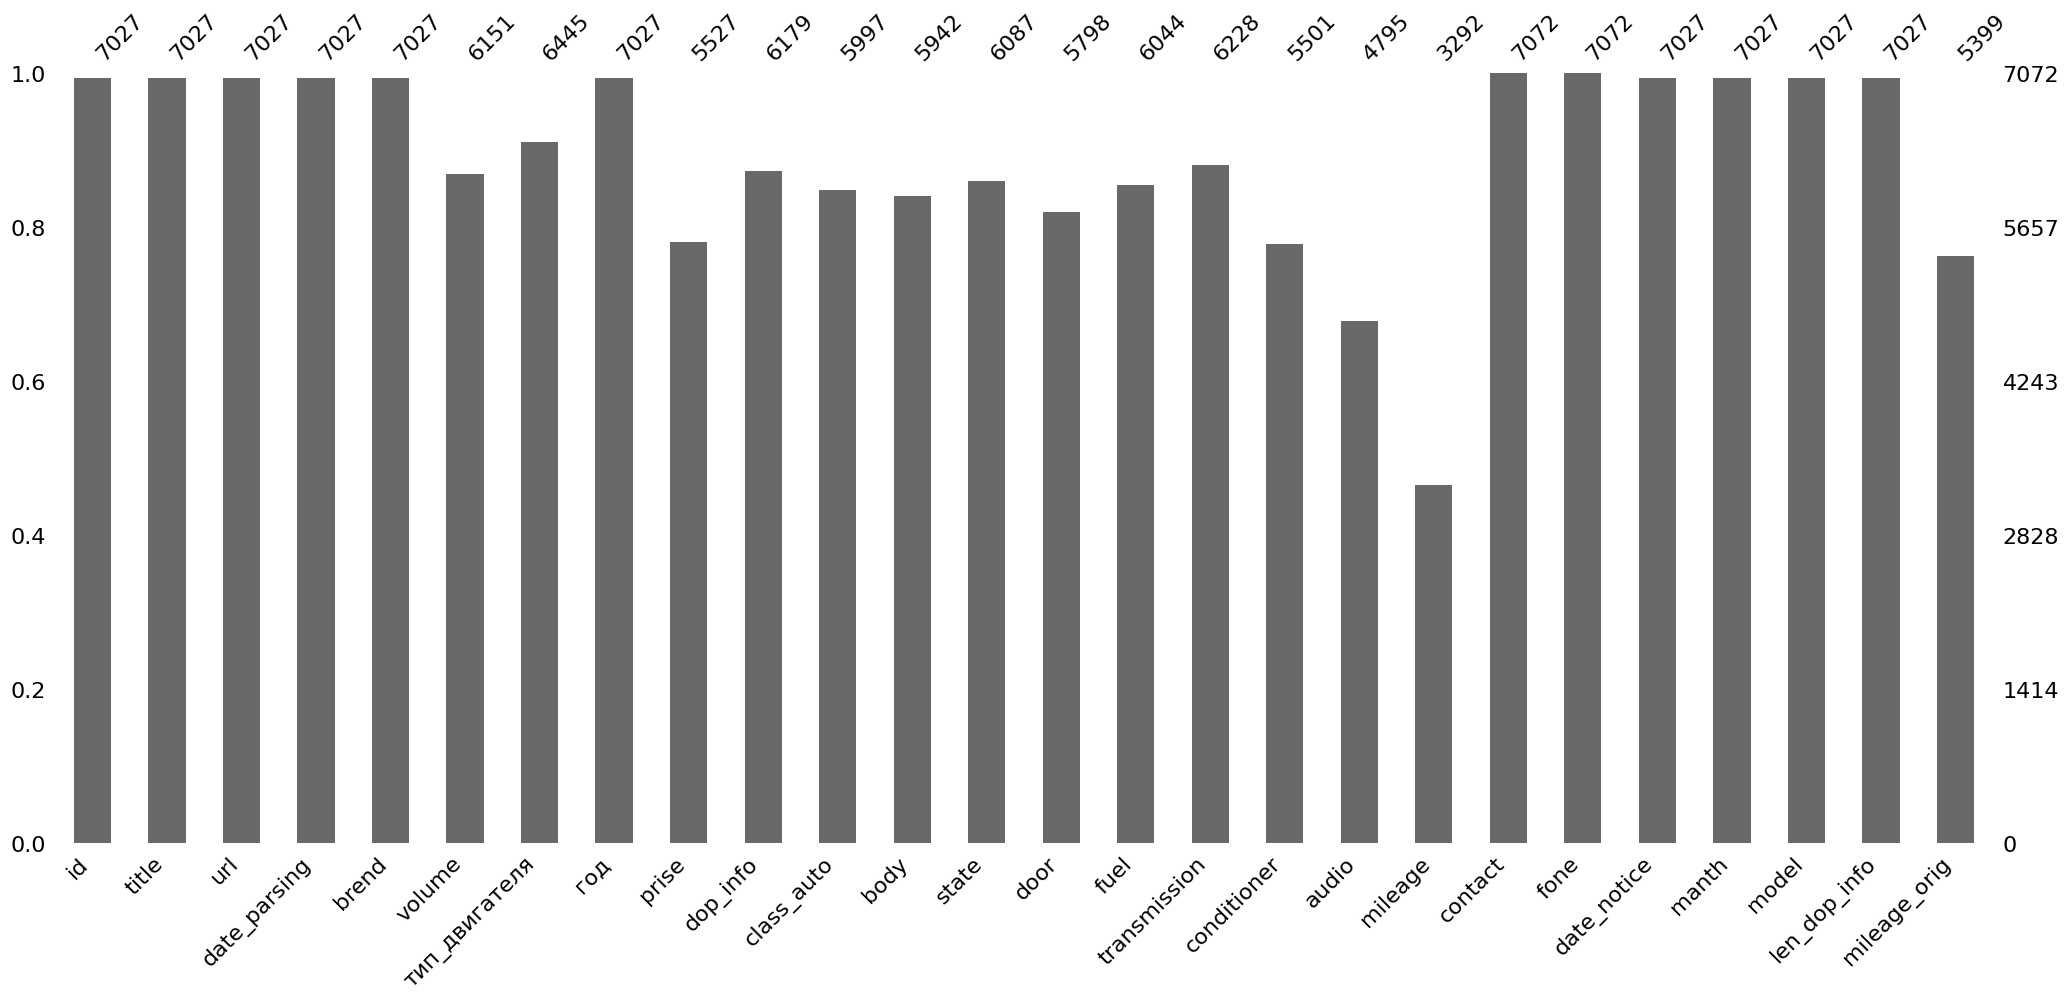

In [76]:
msno.bar(df)

<Axes: >

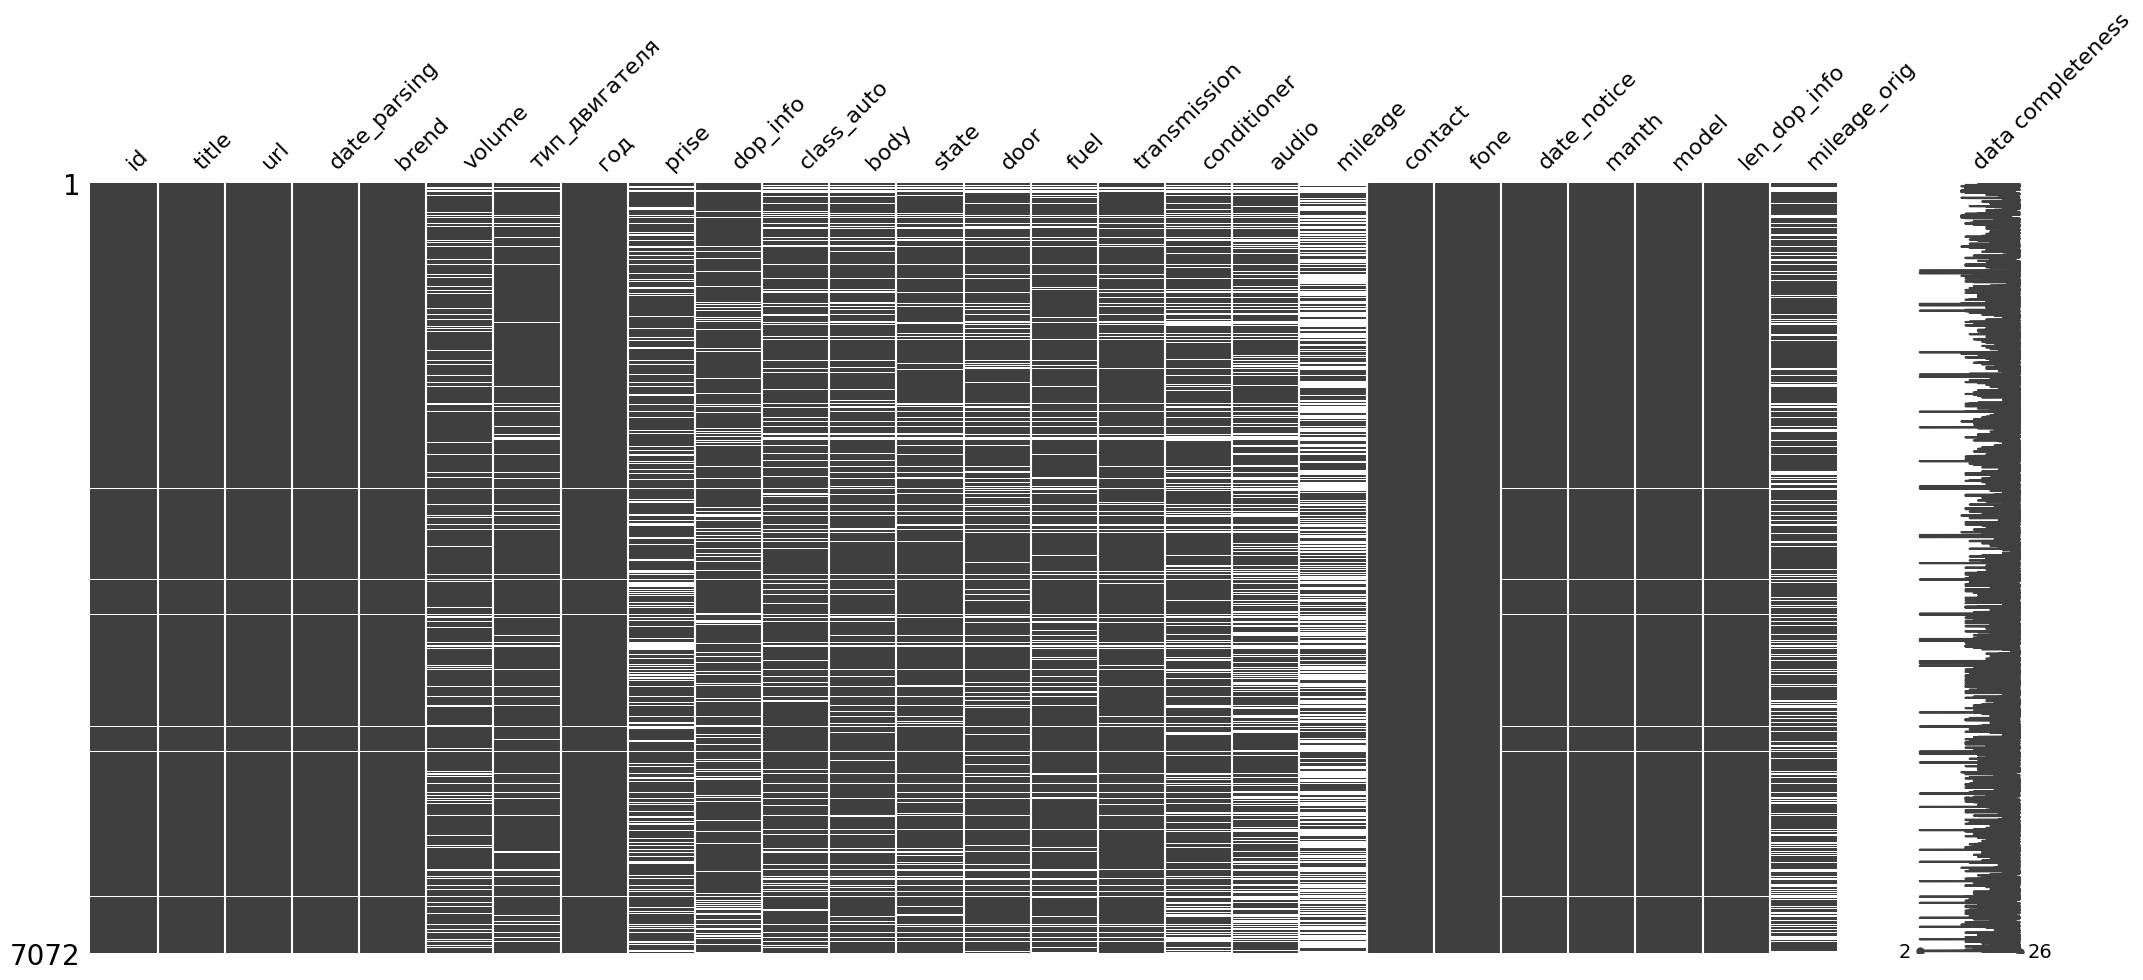

In [77]:
msno.matrix(df, labels=True)

Создаем списки с фичами, таргетом, списки с удаляемыми фичами

In [78]:
df.columns

Index(['id', 'title', 'url', 'date_parsing', 'brend', 'volume',
       'тип_двигателя', 'год', 'prise', 'dop_info', 'class_auto', 'body',
       'state', 'door', 'fuel', 'transmission', 'conditioner', 'audio',
       'mileage', 'contact', 'fone', 'date_notice', 'manth', 'model',
       'len_dop_info', 'mileage_orig'],
      dtype='object')

In [79]:
target = ['prise',]
targets = 'prise'
features = ['id', 'brend', 'volume',
       'тип_двигателя', 'год', 'class_auto', 'body',
       'state', 'door', 'fuel', 'transmission', 'conditioner', 'audio',
       'mileage', 'contact', 'fone', 'date_notice', 'manth', 'model',
       'len_dop_info', 'mileage_orig']
delete_features = ['id', 'title', 'url', 'date_parsing', 'dop_info', ]
categorical_ordinal_features = []
numerical_features = []

In [80]:
for i in features:
    if (df[i].isna().mean()*100) > passs :
        delete_features.append(i)      

In [81]:
features, categorical_features, numerical_features, df = del_features(delete_features, 
                                                                            features, 
                                                                            categorical_ordinal_features, 
                                                                            numerical_features, df)

['id', 'title', 'url', 'date_parsing', 'dop_info']
OK


In [82]:
df_predictiob = df[df['prise'].isna()]

In [83]:
df = df[~(df['prise'].isna())]

In [84]:
(df.isna().mean()* 100).round(2).reset_index().sort_values(by=0, ascending=False)

,index,0
13,mileage,49.16
12,audio,27.74
11,conditioner,17.66
20,mileage_orig,17.26
8,door,13.50
6,body,11.72
5,class_auto,11.24
9,fuel,9.39
7,state,9.19
1,volume,7.11


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5527 entries, 0 to 8167
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   brend          5527 non-null   object        
 1   volume         5134 non-null   float64       
 2   тип_двигателя  5294 non-null   object        
 3   год            5527 non-null   float64       
 4   prise          5527 non-null   float64       
 5   class_auto     4906 non-null   object        
 6   body           4879 non-null   object        
 7   state          5019 non-null   object        
 8   door           4781 non-null   object        
 9   fuel           5008 non-null   object        
 10  transmission   5151 non-null   object        
 11  conditioner    4551 non-null   object        
 12  audio          3994 non-null   object        
 13  mileage        2810 non-null   float64       
 14  contact        5527 non-null   object        
 15  fone           5527 non-nu

# Анализ

## Разбиение данных

In [86]:
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

brend: 68
volume: 237
тип_двигателя: 5
год: 55
prise: 618
class_auto: 2
body: 14
state: 6
door: 3
fuel: 4
transmission: 6
conditioner: 3
audio: 4
mileage: 627
contact: 1118
fone: 3698
date_notice: 5415
manth: 24
model: 569
len_dop_info: 931
mileage_orig: 1022


Уникальные записи помогут нам разделить категориальные и числовые данные. В будущем это будет полезно для пайплайна. Признак `пол` и `одышцианприст` имеет всего 2 уникальных значений, и мы будем использовать это значение как порог для разделения данных на категории.

In [87]:
print('delete_features=[')
for column in df.columns:
    if df[column].dtype != 'object' and len(df[column].dropna().unique())<2:
        print(f"    '{column}',")
print(']\ncategorical_nominal_features = [')
for column in df.columns:
    if df[column].dtype == 'object' or (len(df[column].dropna().unique())>=2 and len(df[column].unique())<=14):
        print(f"    '{column}',")
print(']\ncategorical_ordinal_features = [\n')
print(']\nnumerical_features = [')
for column in df.columns:
    if df[column].dtype != 'object' and len(df[column].dropna().unique())>14:
        print(f"    '{column}',")
print(']')

delete_features=[
]
categorical_nominal_features = [
    'brend',
    'тип_двигателя',
    'class_auto',
    'body',
    'state',
    'door',
    'fuel',
    'transmission',
    'conditioner',
    'audio',
    'contact',
    'fone',
    'model',
]
categorical_ordinal_features = [

]
numerical_features = [
    'volume',
    'год',
    'prise',
    'mileage',
    'date_notice',
    'manth',
    'len_dop_info',
    'mileage_orig',
]


In [103]:
delete_features=[
]
categorical_nominal_features = [
    'brend',
    'тип_двигателя',
    'class_auto',
    'body',
    'state',
    'door',
    'fuel',
    'transmission',
    'conditioner',
    'audio',
    'contact',
    'fone',
    'model',
]
categorical_ordinal_features = [

]
numerical_features = [
    'volume',
    'год',
    'prise',
    'mileage',
    'len_dop_info',
    'mileage_orig',
]

In [89]:
len(categorical_nominal_features)

13

In [90]:
len(numerical_features)

8

## Таргет

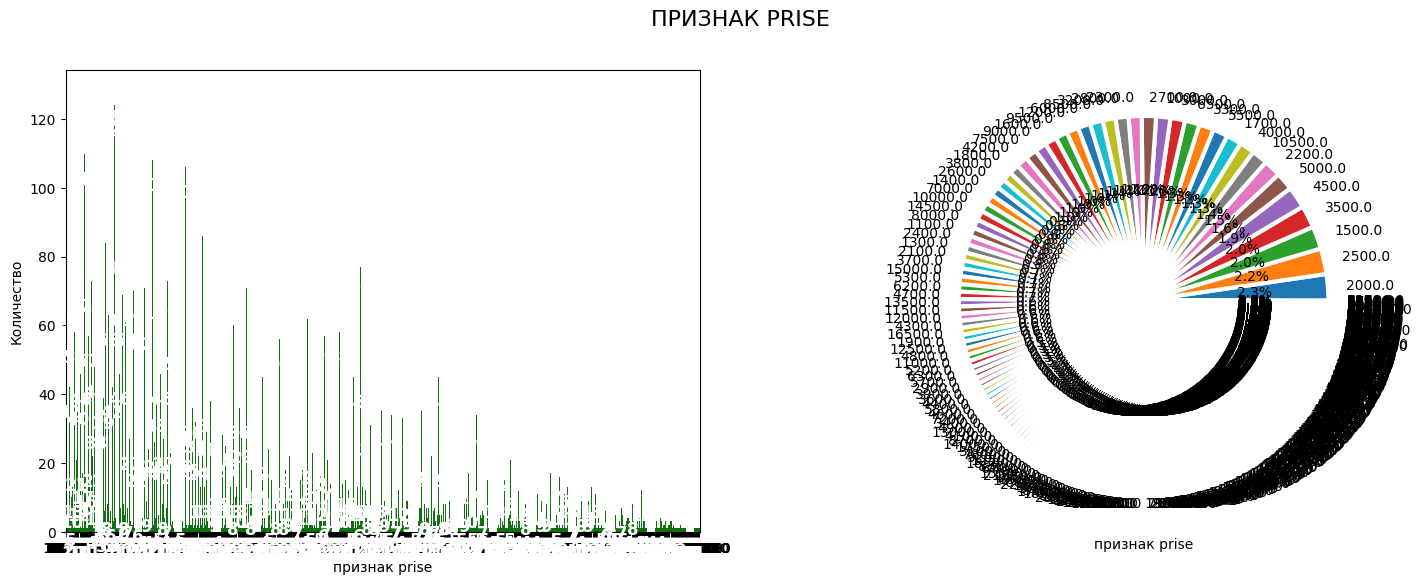

In [110]:
show_categorical_feature_by_list(df, target)

In [92]:
df[targets].value_counts(normalize=True)

prise
2000.00    0.02
2500.00    0.02
1500.00    0.02
3500.00    0.02
4500.00    0.02
           ... 
13764.00   0.00
24600.00   0.00
4718.00    0.00
21600.00   0.00
7250.00    0.00
Name: proportion, Length: 618, dtype: float64

Классы в целевой переменной не сбалансированны и сильно отличаются

## Категориальные признаки

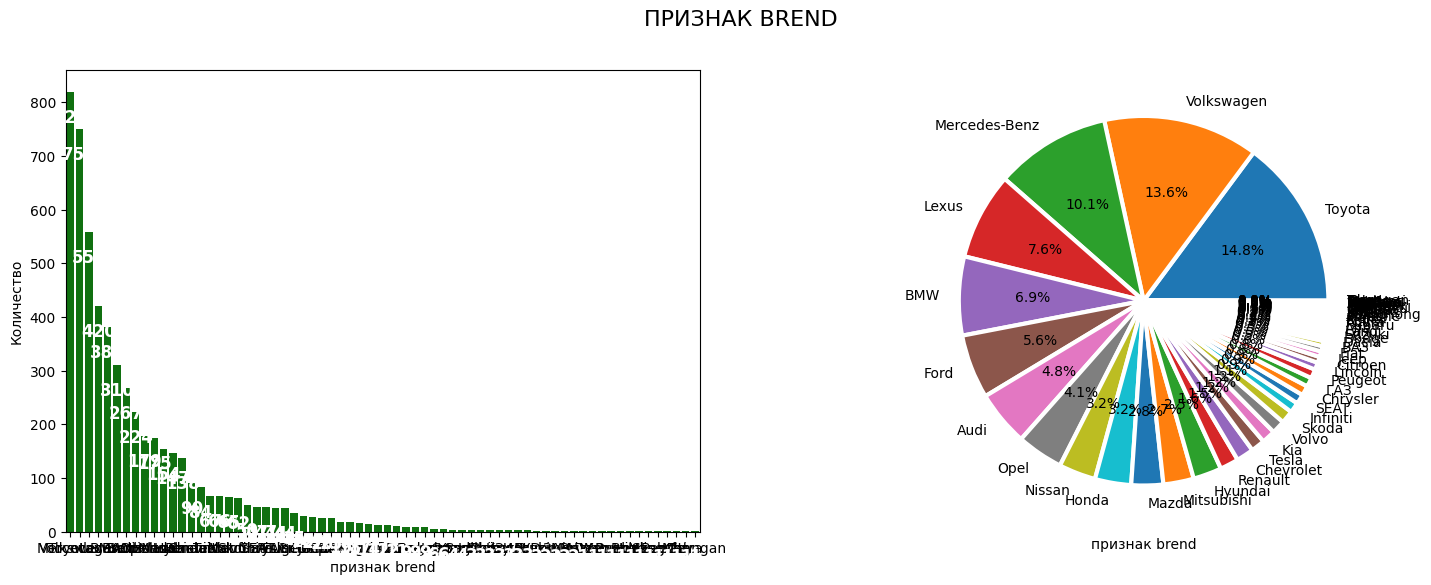

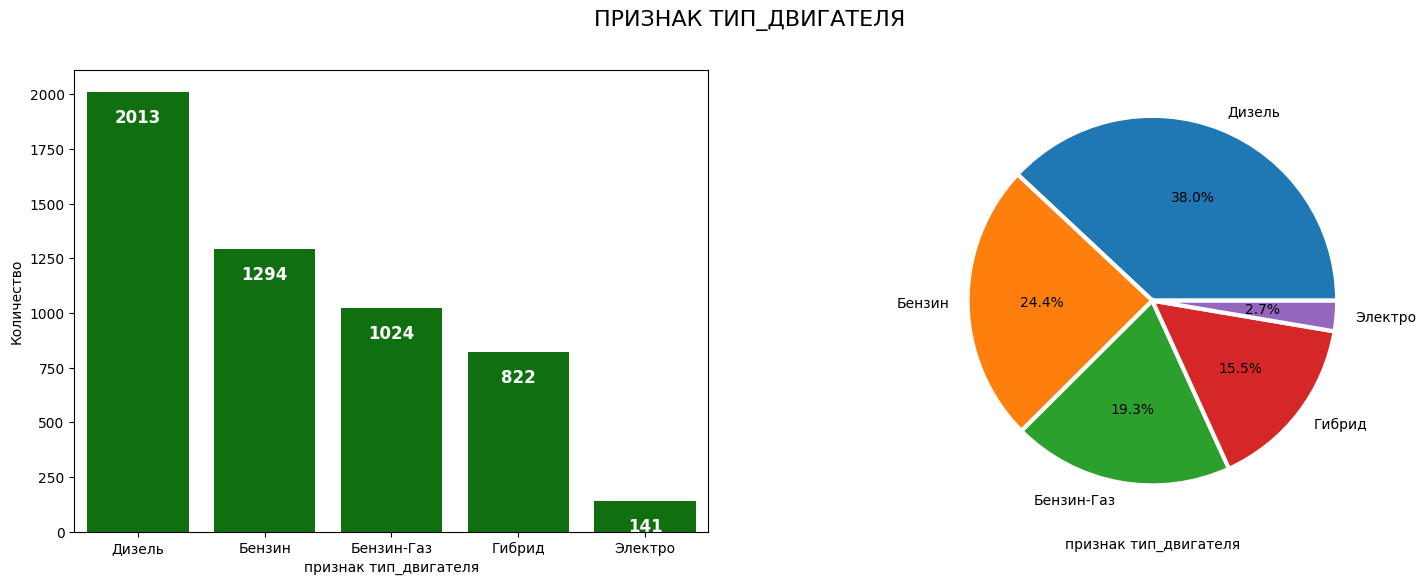

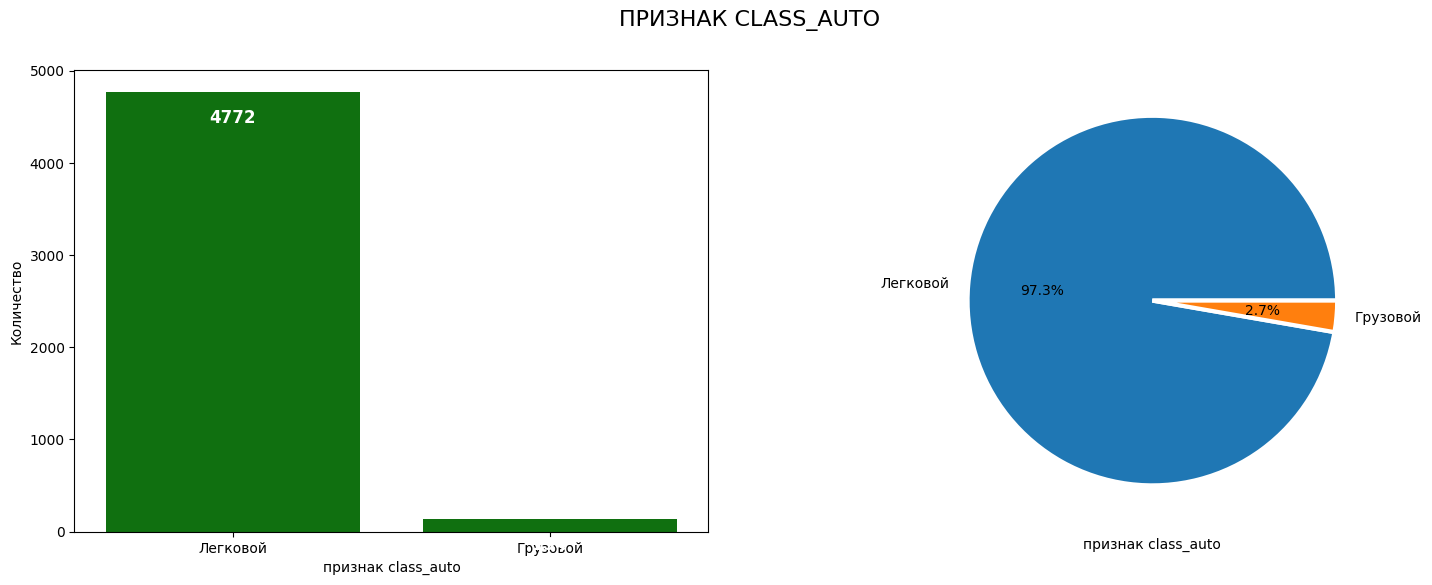

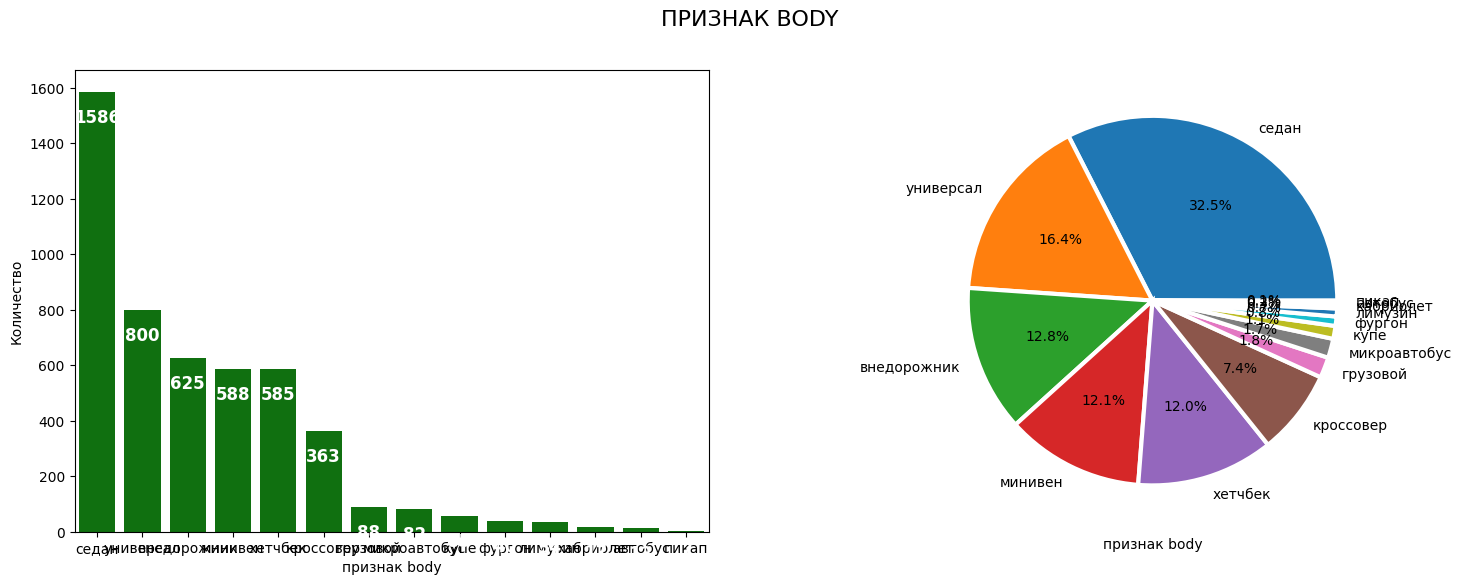

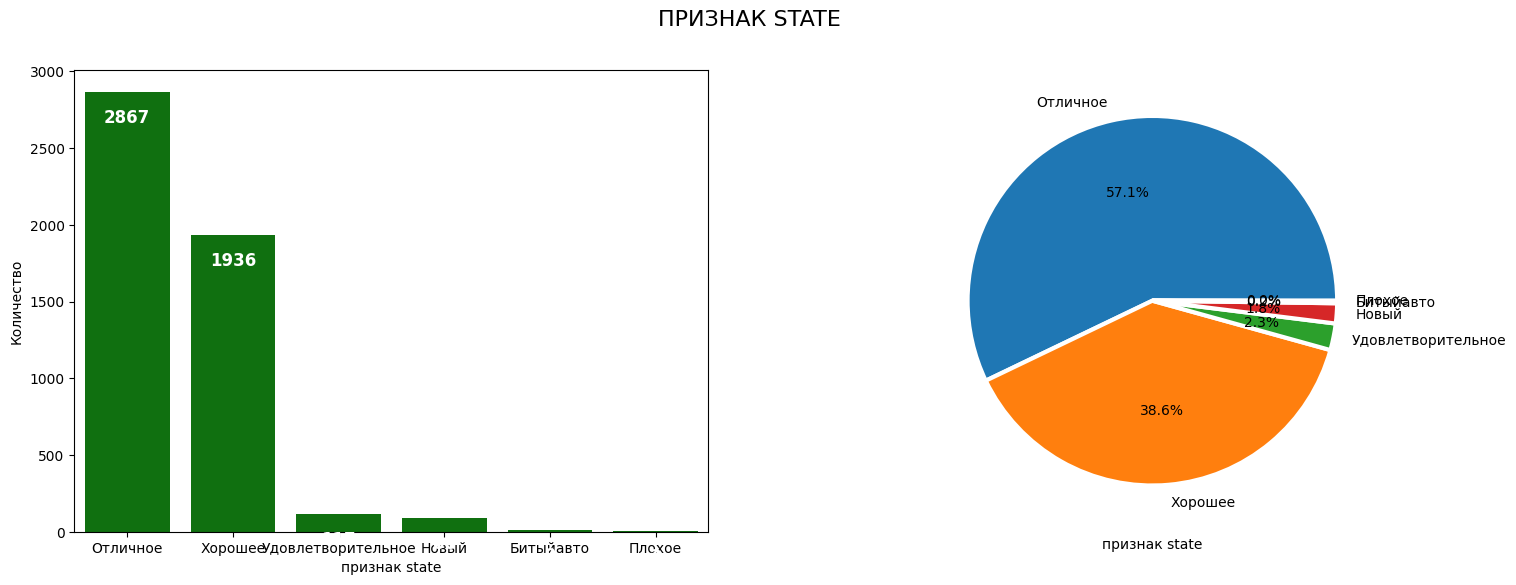

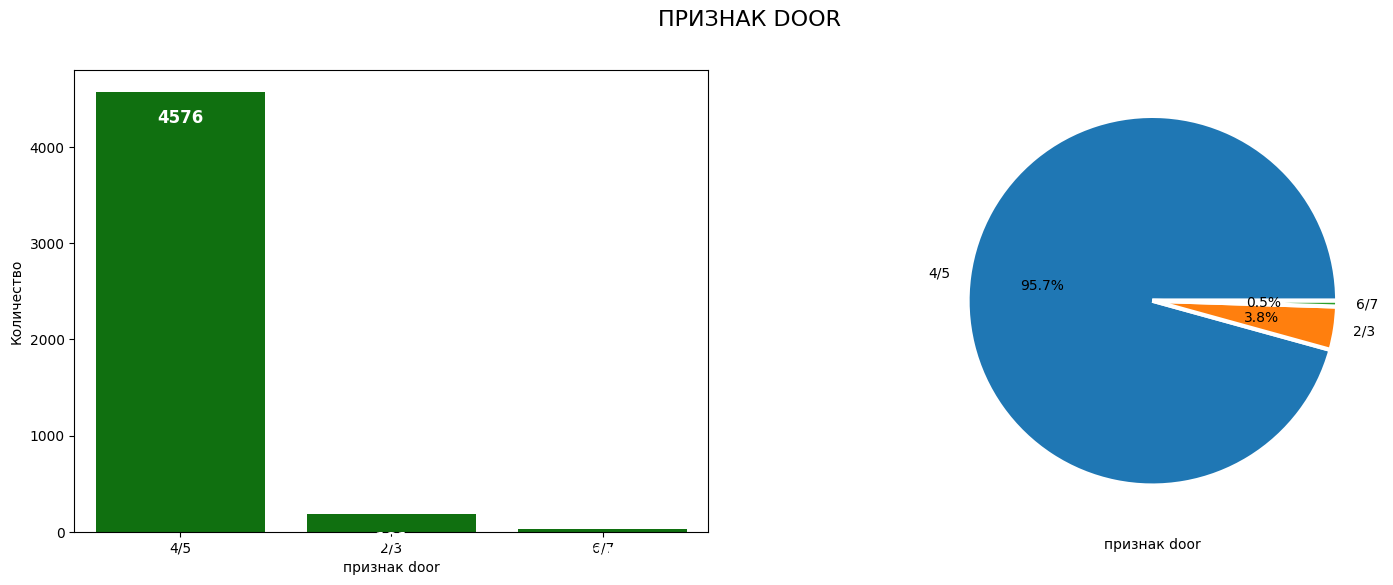

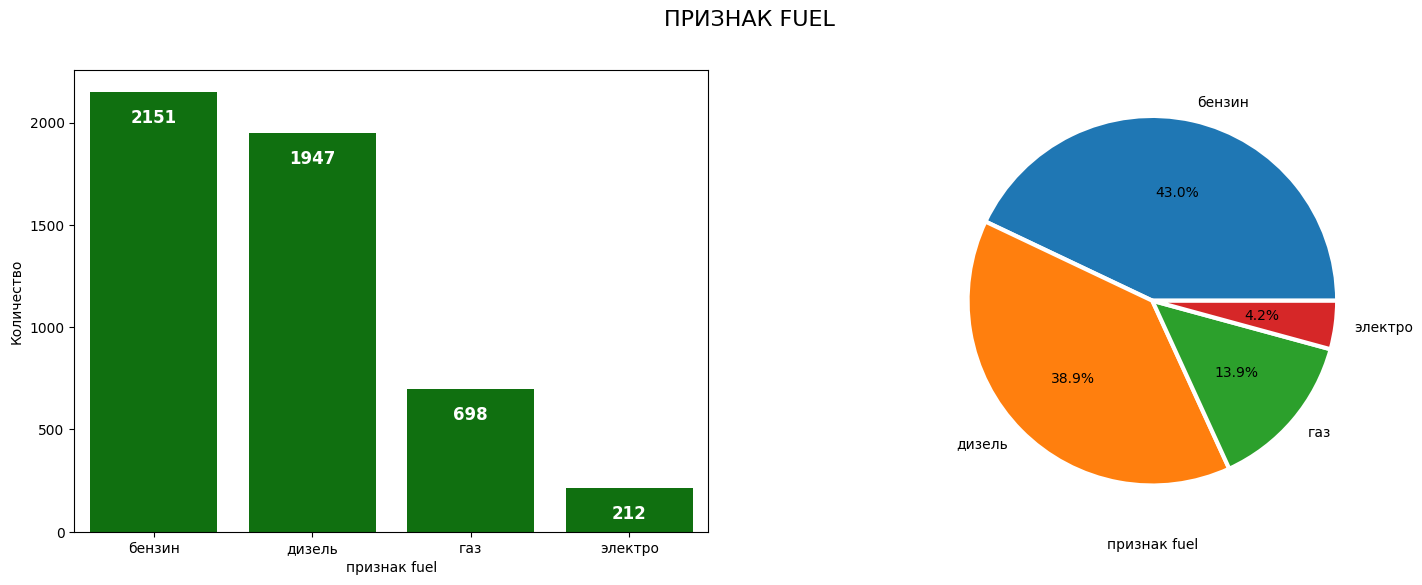

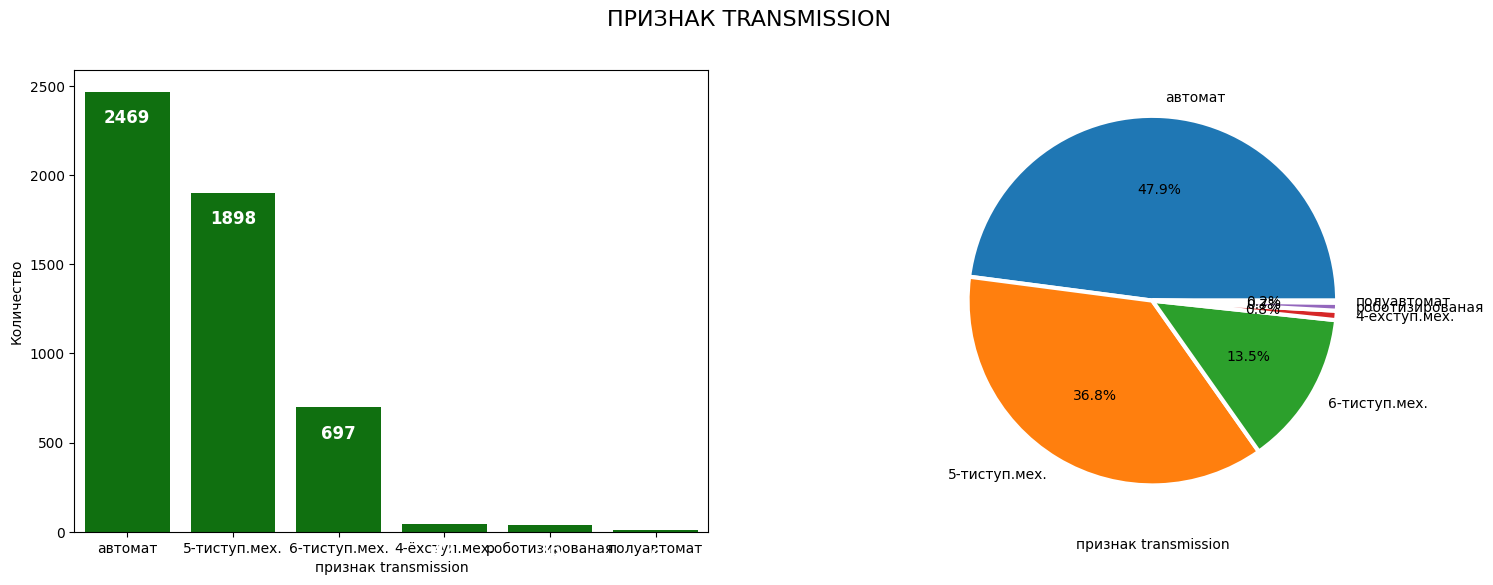

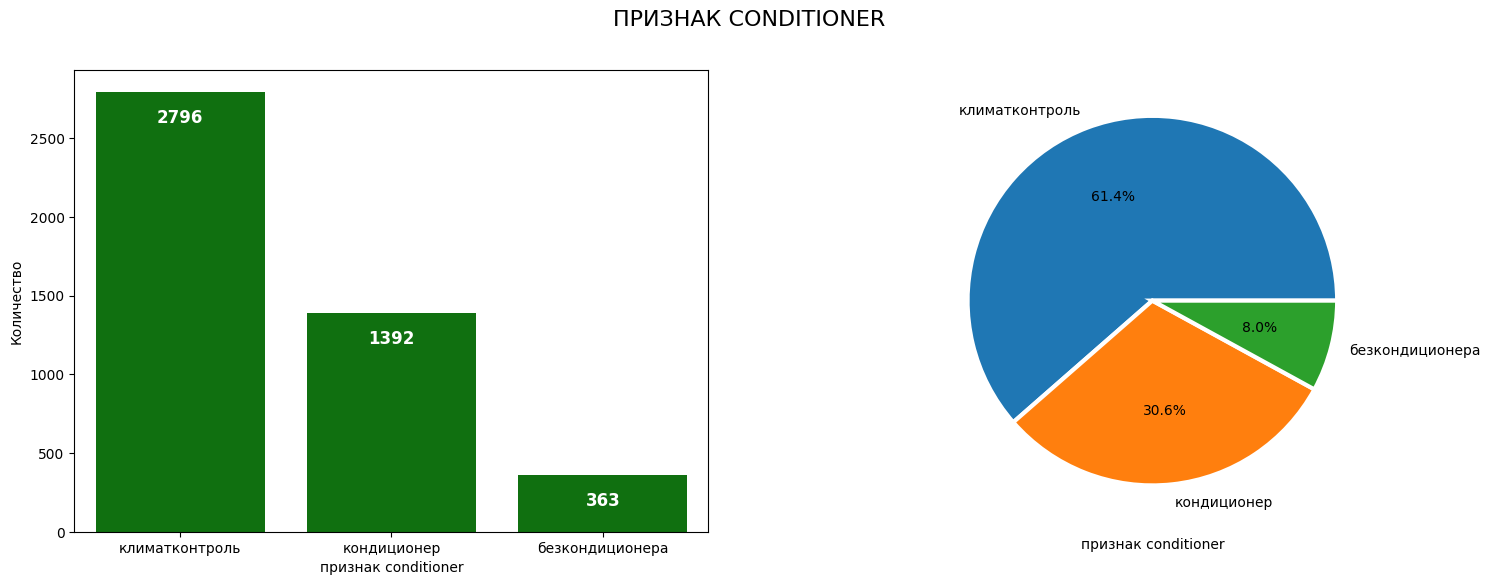

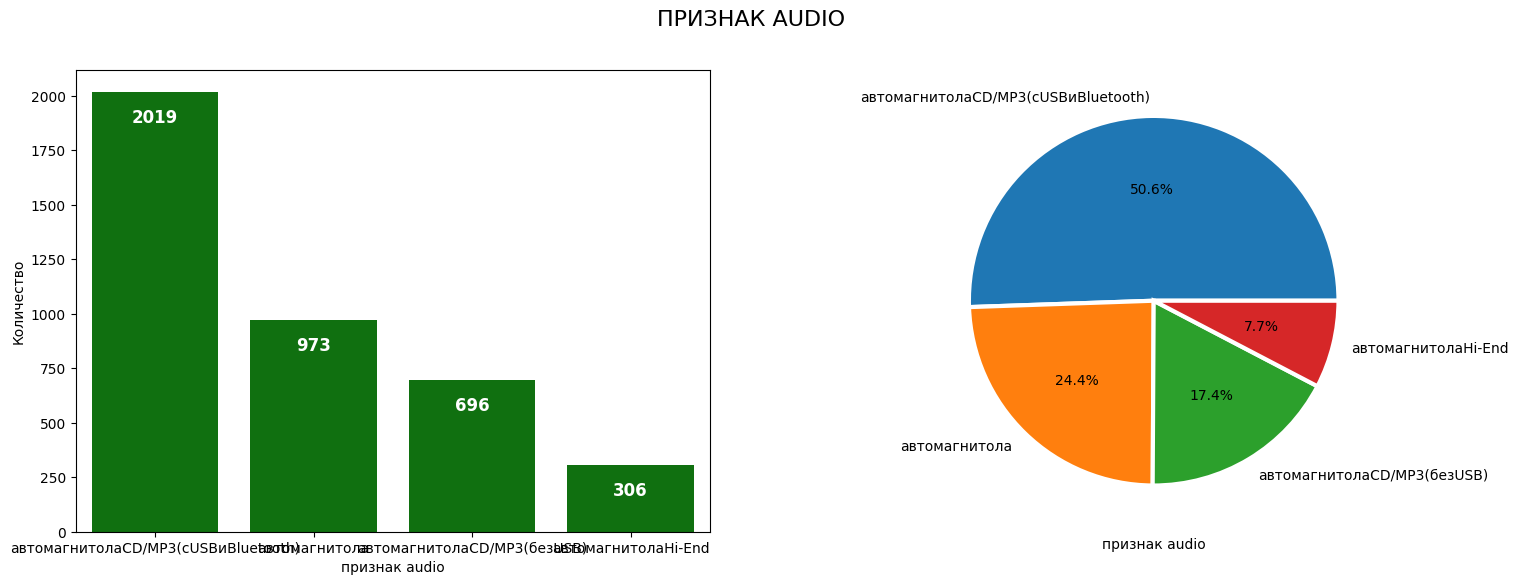

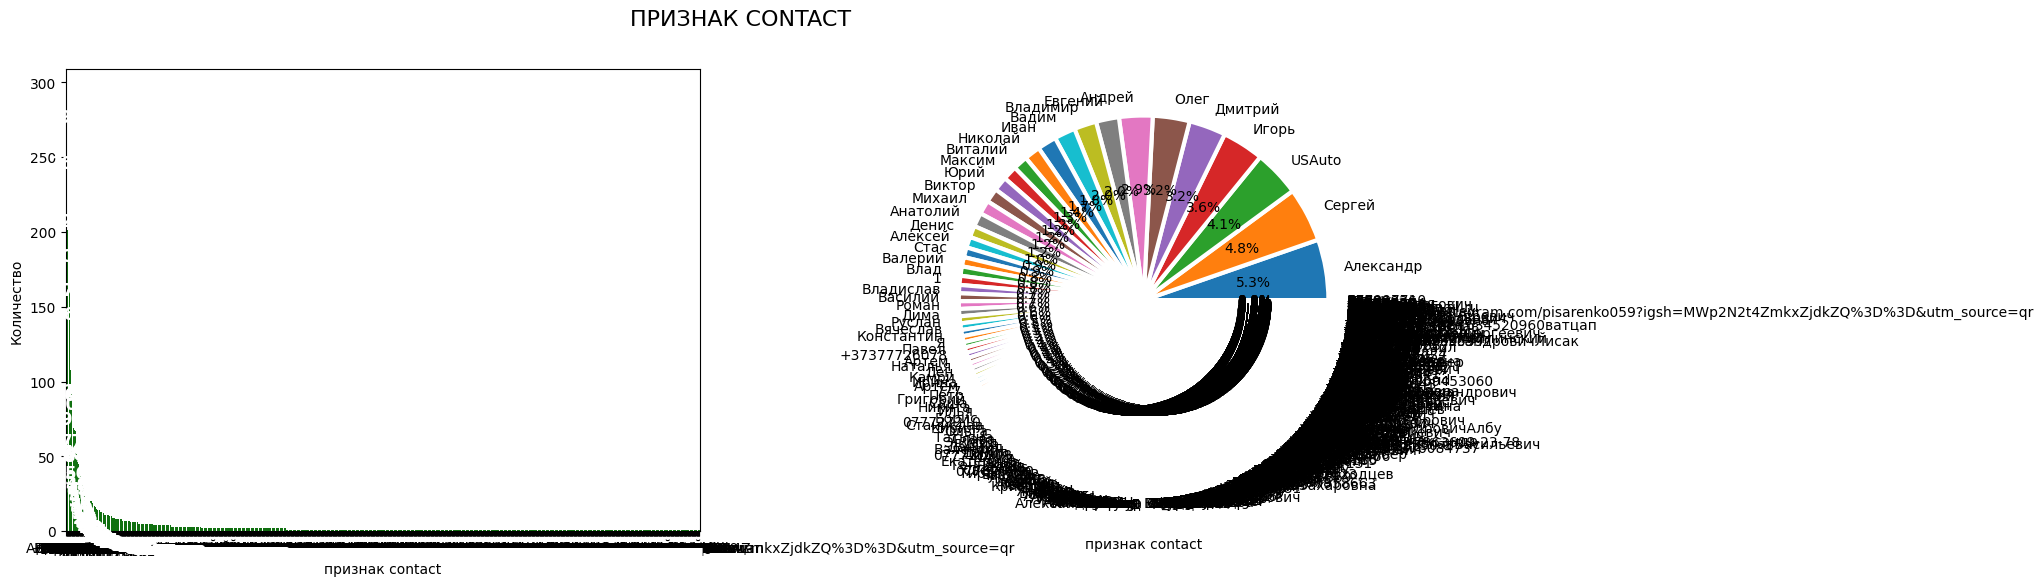

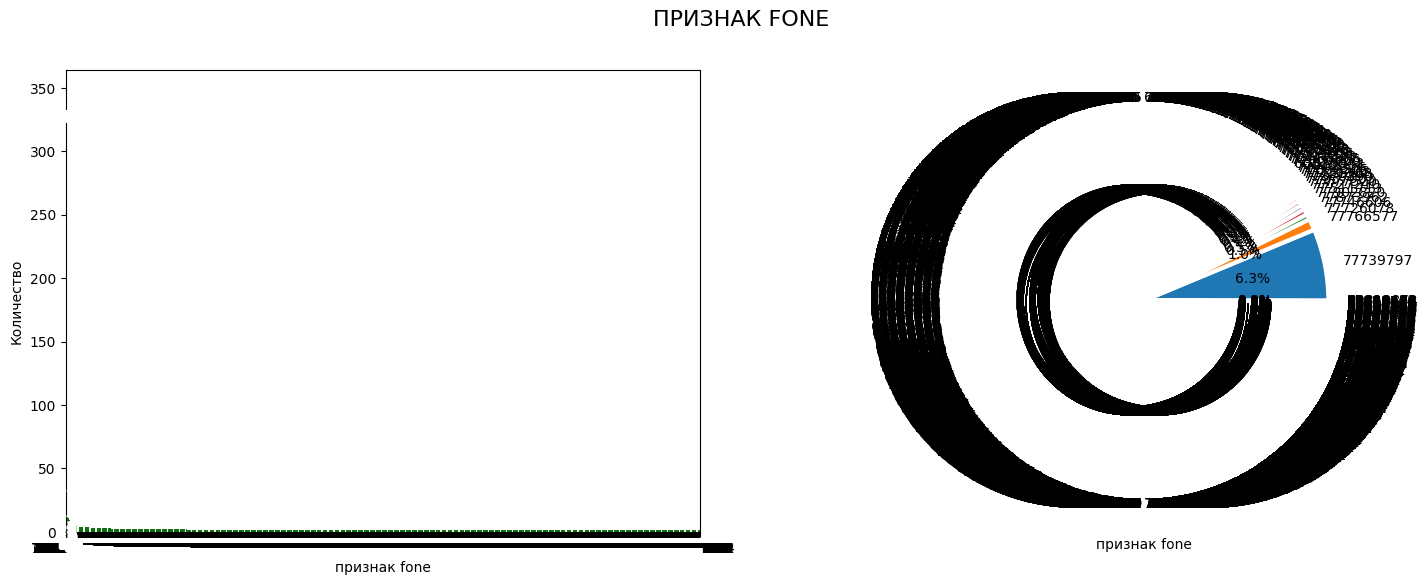

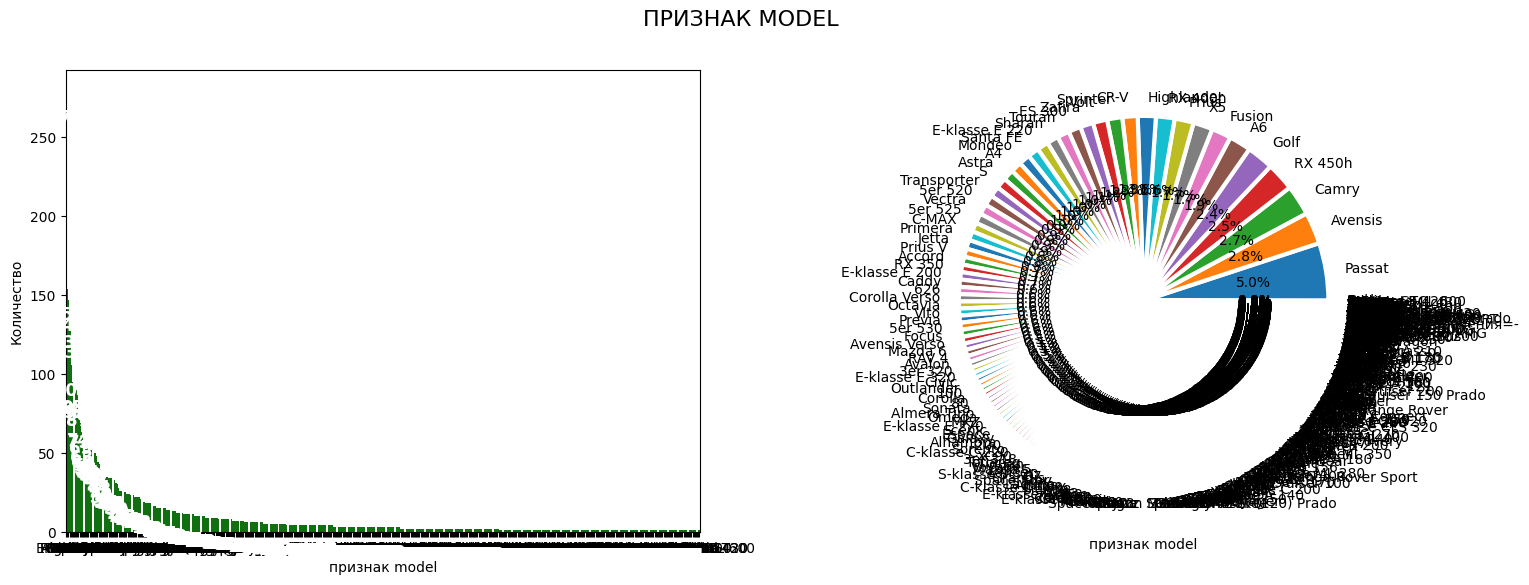

In [111]:
show_categorical_feature_by_list(df, categorical_nominal_features)

In [104]:
for i in categorical_nominal_features:
    print(df[i].value_counts(dropna=False))
    print('-'*100)

brend
Toyota           820
Volkswagen       751
Mercedes-Benz    559
Lexus            420
BMW              381
Ford             310
Audi             267
Opel             224
Nissan           179
Honda            175
Mazda            154
Mitsubishi       147
Hyundai          138
Renault           90
Chevrolet         84
Tesla             67
Kia               66
Volvo             65
Skoda             62
Infiniti          50
SEAT              47
Chrysler          47
ГАЗ               44
Peugeot           44
Lincoln           35
Citroen           29
Jeep              27
Fiat              26
ВАЗ               25
Dacia             19
Dodge             18
Suzuki            17
Land              14
Alfa              12
Subaru            12
Acura             11
Rover              9
Iveko              9
Porsche            9
SsangYong          6
Jaguar             6
Smart              4
Jawa               4
Cadillac           3
Lancia             3
Chery              3
Daihatsu           3
ЗИЛ    

Бинарные признаки несбалансированы

In [95]:
show_categorical_feature_by_list(df, categorical_ordinal_features)

In [96]:
for i in categorical_ordinal_features:
    print(df[i].value_counts(dropna=False))
    print('-'*100)

Порядковых категориальных признаков нет

## Числовые признаки

In [105]:
numerical_features

['volume', 'год', 'prise', 'mileage', 'len_dop_info', 'mileage_orig']

<Figure size 640x480 with 0 Axes>

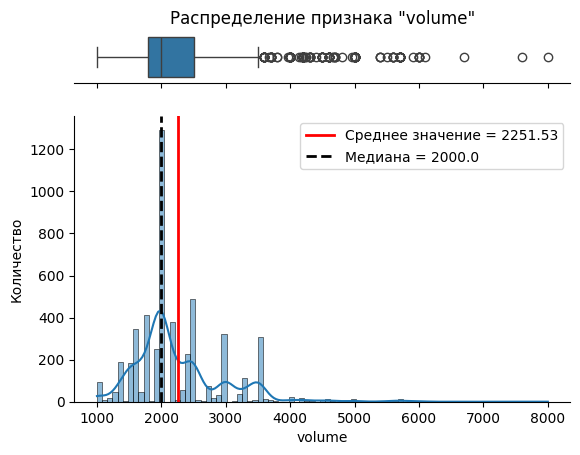

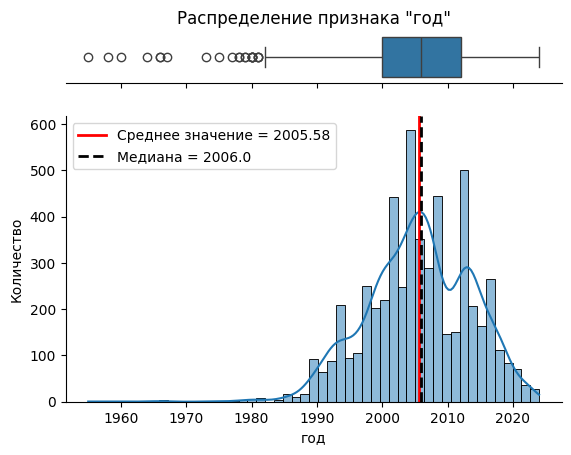

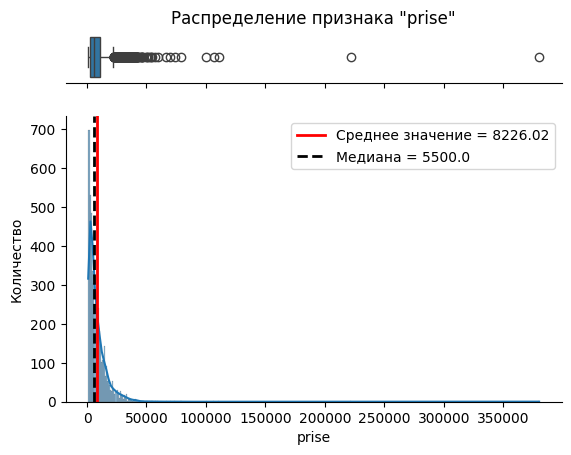

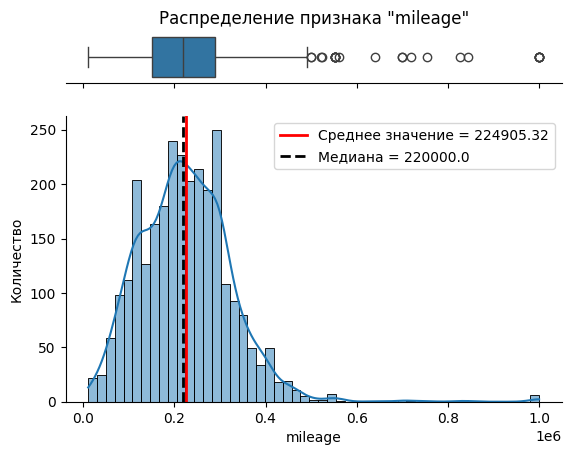

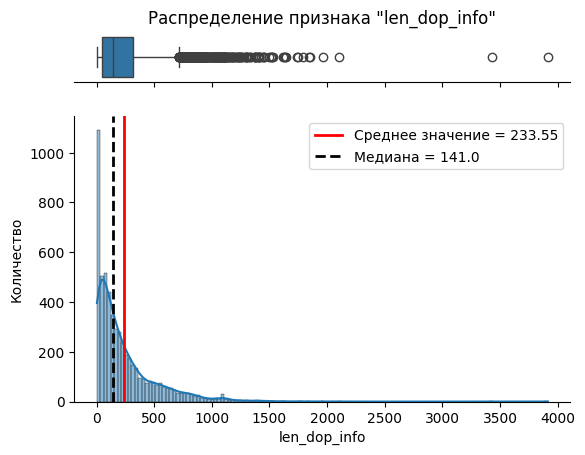

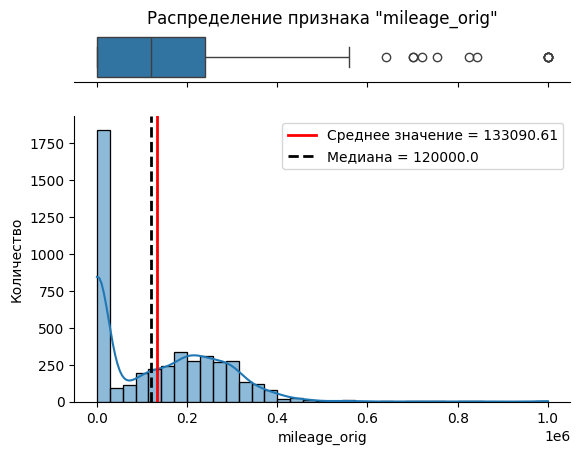

In [106]:
for i in range(len(numerical_features)):
    col = numerical_features[i]
    plt.figure(i)
    hist_underbox(data=df[col],title=f'Распределение признака "{col}"')

**После анализа количественных признаков мы можем сделать следующие выводы:**
* В значениях имеются некоторые выбросы, посмотрим сколько строк с выбрасами

Некоторые количественные данные распределены не нормально

явного деления количественных признаков датасета по таргету не проссматривается.

## Корреляционный анализ

In [123]:
df

,brend,volume,тип_двигателя,год,prise,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice,manth,model,len_dop_info,mileage_orig
0,Lexus,3300.00,Гибрид,2009.00,10800.00,Легковой,внедорожник,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитола,168000.00,Тирасполь,77904221,2024-10-01 14:57:00,2024-10,RX 400h,3.00,168000.00
3,Nissan,2500.00,Бензин,2015.00,10000.00,Легковой,внедорожник,NaN,NaN,NaN,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBиBluetooth),NaN,Сергей,77768794,2024-10-01 14:42:00,2024-10,Rogue,54.00,138.00
5,Lexus,2500.00,Гибрид,2013.00,15900.00,Легковой,седан,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBиBluetooth),NaN,Igor,77777139,2024-09-27 09:11:00,2024-09,ES 300,594.00,145.00
6,Volkswagen,2000.00,Дизель,2004.00,4500.00,Легковой,минивен,Отличное,4/5,дизель,6-тиступ.мех.,климатконтроль,автомагнитола,NaN,Кристина,77954052,2024-10-01 14:33:00,2024-10,Touareg,120.00,335.00
7,Toyota,2400.00,Бензин-Газ,2007.00,5500.00,Легковой,универсал,Отличное,4/5,газ,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBиBluetooth),NaN,МиихаилТатьяна,77827520,2024-10-01 14:32:00,2024-10,Avensis,517.00,197.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,Mazda,1800.00,Бензин,1995.00,1300.00,Легковой,седан,Хорошее,4/5,бензин,5-тиступ.мех.,NaN,NaN,NaN,Слава,77905469,2022-11-14 11:52:00,2022-11,626,34.00,NaN
8162,Mazda,1600.00,Бензин,1994.00,1350.00,Легковой,седан,Хорошее,4/5,NaN,5-тиступ.мех.,NaN,автомагнитола,NaN,Татьяна,77719129,2022-11-14 10:27:00,2022-11,Xedos 6,3.00,NaN
8165,Mercedes-Benz,2700.00,Дизель,2003.00,4600.00,Легковой,седан,Отличное,NaN,дизель,автомат,климатконтроль,NaN,NaN,Gmail,77831962,2022-11-13 14:55:00,2022-11,E-klasse E 270,25.00,NaN
8166,Kia,NaN,Бензин-Газ,2003.00,3100.00,Легковой,минивен,Отличное,4/5,газ,5-тиступ.мех.,климатконтроль,автомагнитола,NaN,Сергей,69810872,2022-11-13 11:41:00,2022-11,Carens,99.00,1.00


In [122]:
all_features = target + categorical_nominal_features + categorical_ordinal_features + numerical_features 
cor_matrix = df[all_features].phik_matrix(interval_cols=all_features)
plt.figure(figsize=(36, 24))
sns.heatmap(cor_matrix, 
            annot=True, 
            linewidths=0.5, 
            cmap='coolwarm')
plt.show()

ValueError: could not convert string to float: 'Lexus'

Наиболее сильно влияют на целевой признак следующие признаки:

In [ ]:
cor_matrix[target].sort_values(by=target,ascending=False).head(10)

Мультиколлинеарность наблюдается у следующих признаков:

In [ ]:
mult_col = []
for column in cor_matrix.columns:
    for i in cor_matrix.columns:
        value = cor_matrix[column][i]
        if column != i and value > 0.85 :
            if cor_matrix[targets][column] > cor_matrix[targets][i]:
                mult_col.append([column, cor_matrix[targets][column], i, cor_matrix[targets][i], value])
            elif cor_matrix[targets][column] < cor_matrix[targets][i]:
                mult_col.append([i, cor_matrix[targets][i], column, cor_matrix[targets][column], value])
            else:
                if column < i:
                    mult_col.append([column, cor_matrix[targets][column], i, cor_matrix[targets][i], value])
                else:
                    mult_col.append([i, cor_matrix[targets][i], column, cor_matrix[targets][column], value])        

            
t = pd.DataFrame(mult_col, columns=['first', 'f_target_corr', 'second',
                                    's_target_corr', 'f_s_corr']).sort_values('f_target_corr',
                                                                              ascending=False).reset_index(drop=True)
t = t.drop_duplicates()
delete_features = t.second.unique()
t

In [ ]:
categorical_nominal_features, categorical_ordinal_features, numerical_features, no_anomalies_df = del_features(delete_features, 
                                                                                                  categorical_nominal_features, 
                                                                                                  categorical_ordinal_features, 
                                                                                                  numerical_features, 
                                                                                                  df)

Удаляем следующие мултиколениарные признаки 'ксрлж' 'кдолж' 'устьелла' 'ствол_ла' 'рост' 'бса'

Проверим, сколько осталось количественныхи котегориальных признаков

In [ ]:
len(categorical_nominal_features)

In [ ]:
len(categorical_ordinal_features)

In [ ]:
categorical_features = categorical_nominal_features + categorical_ordinal_features
len(categorical_features)

In [ ]:
len(numerical_features)

В данных осталось 13 количественных признаков и 8 котегориальных

## Промежуточные выводы

* Классы в целевой переменной не сбалансированны и сильно отличаются
* Бинарные признаки не сбалансированны
* Порядковых категориальных признаков нет
* Некоторые количественные данные распределены не нормально
* В значениях имеются некоторые выбросы, удаляем их из данных но сохраняем эти выбросы в отдельном датасете. 